In [1679]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns 
import bokeh.plotting as bkh
from bokeh.io import output_notebook
from datetime import datetime
from datetime import timedelta
from sgp4.earth_gravity import wgs72 #wgs84, wgs72old
from sgp4.io import twoline2rv
import sklearn.preprocessing as ppimport
from bokeh.models import ColumnDataSource, DataRange1d, Plot, LinearAxis, Grid, Range1d, LabelSet, Label, LogAxis, GMapOptions
from bokeh.io import export_svgs, output_file, show, export_png
from bokeh.transform import dodge
import bokeh.colors as colors
from bokeh.colors import Color
from bokeh.models.ranges import FactorRange
from mpl_toolkits.mplot3d import Axes3D 
import plotly.graph_objects as go
from sgp4.earth_gravity import wgs72 #wgs84, wgs72old
from sgp4.io import twoline2rv
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import leastsq, curve_fit
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.metrics import mean_squared_error
import math

In [502]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [503]:
dfdeb = pickle.load(open('dfdeb_fc.p', 'rb'))
dfdeb_m = pickle.load(open('dfdeb_m_fc.p', 'rb'))

In [999]:
dfdeb.head()

,m,argp,bstar,ddn_o6,dn_o2,ecc,epoch_day,epoch_year,inc,int_desig,n,norad,raan,rev_num,line1,line2,object_id,object_name,country,period,inclination,apogee,perigee,rcs_size,launch,debc,apo,peri,date,datetimes,x,y,z
11477,277.0305,84.1924,0.000106,0.0,0.000002,0.009775,343.944544,2018,66.7295,61015D,14.231585,119,299.5038,96720,1 00119U 61015D 18343.94454394 +.00000169 +0...,2 00119 066.7295 299.5038 0097752 084.1924 277...,1961-015D,THOR ABLESTAR DEB,US,101.18,66.73,891.0,738.0,MEDIUM,1961-06-29,True,7263.139166,7122.516505,2018.939739,2018-12-10 22:40:08.596416,1637.533815,4415.087376,-5486.342149
11478,277.7405,83.4810,0.000129,0.0,0.000002,0.009778,344.858134,2018,66.7296,61015D,14.231592,119,297.1432,96733,1 00119U 61015D 18344.85813364 +.00000223 +0...,2 00119 066.7296 297.1432 0097776 083.4810 277...,1961-015D,THOR ABLESTAR DEB,US,101.18,66.73,891.0,738.0,MEDIUM,1961-06-29,True,7263.154061,7122.496920,2018.942235,2018-12-11 20:35:42.746496,412.351193,6369.916536,-3442.251296
11479,278.0692,83.1515,0.000138,0.0,0.000002,0.009778,345.279790,2018,66.7296,61015D,14.231594,119,296.0537,96739,1 00119U 61015D 18345.27979033 +.00000244 +0...,2 00119 066.7296 296.0537 0097780 083.1515 278...,1961-015D,THOR ABLESTAR DEB,US,101.18,66.73,891.0,738.0,MEDIUM,1961-06-29,True,7263.156012,7122.493135,2018.943387,2018-12-12 06:42:53.884512,-102.175022,6833.965457,-2442.432840
11480,278.7813,82.4378,0.000155,0.0,0.000003,0.009780,346.193380,2018,66.7297,61015D,14.231601,119,293.6931,96795,1 00119U 61015D 18346.19337954 +.00000286 +0...,2 00119 066.7297 293.6931 0097799 082.4378 278...,1961-015D,THOR ABLESTAR DEB,US,101.18,66.73,891.0,738.0,MEDIUM,1961-06-29,True,7263.167586,7122.477417,2018.945884,2018-12-13 04:38:27.992256,-1059.657250,7175.912779,-377.555899
11481,279.3214,81.8966,0.000168,0.0,0.000003,0.009784,346.896140,2018,66.7297,61015D,14.231606,119,291.8774,96762,1 00119U 61015D 18346.89614006 +.00000316 +0...,2 00119 066.7297 291.8774 0097835 081.8966 279...,1961-015D,THOR ABLESTAR DEB,US,101.18,66.73,891.0,738.0,MEDIUM,1961-06-29,True,7263.191561,7122.449641,2018.947804,2018-12-13 21:30:26.501184,-1707.622111,6956.813002,1197.298150


In [504]:
def xyz_model(line1, line2, date):
    satellite = twoline2rv(line1, line2, wgs72)
 #   pass
    #position, velocity = satellite.propagate(
    #2000, 6, 29, 12, 50, 19) # year month day hour min sec
    position, velocity = satellite.propagate(
    date.year, date.month, date.day, date.hour, date.minute, date.second) # year month day hour min sec
    return position

In [505]:
def coordcalt(line1, line2, date):
    xcon = list()
    ycon = list()
    zcon = list()
    for i in range(len(line1)):
        xyz = xyz_model(line1[i], line2[i], datetest)
        xcon.append(xyz[0])
        ycon.append(xyz[1])
        zcon.append(xyz[2])
    return xcon, ycon, zcon

In [1299]:
def calorbitxyz(inc, n, raan, ecc, argp, npoints = 100):
    #raan = np.pi / 180
    #inc = np.pi / 180
    x = list()
    y = list()
    z = list()
    mu = 3.986004418E5 * (3600 * 24) ** 2
    earthreq = 6378
    apo = np.power(mu / (4. * (np.pi * n) ** 2), 1. / 3.)
    peri = apo * (1 - ecc)
    a = (apo + peri) / 2
    oecc = np.sqrt(1 - ecc ** 2)
    b = a * oecc
    b2 = b * b
    a2 = a * a
    xp = np.linspace(-a, a, npoints) 
    argp_cos = np.cos(argp - 90)
    argp_sin = np.sin(argp - 90) #periapsis regarding to x-axis
    raan_cos = np.cos(raan)
    raan_sin = np.sin(raan)
    inc_cos = np.cos(inc)
    inc_sin = np.sin(inc)
    #print(xp)
    for i in xp:
        x.append(i)
        x.append(i)
        yabs = np.sqrt(b2 - i * i * b2 / a2)
        y.append(yabs)
        y.append(-yabs)
    x = np.array(x)
    y = np.array(y)
    xn = x * argp_cos - y * argp_sin
    yn = y * argp_cos + x * argp_sin
    x = xn
    y = yn
    xn = x * raan_cos - y * raan_sin
    yn = y * raan_cos + x * raan_sin
    z = xn * np.sin(inc)
    xn *= np.cos(inc)
    x = xn * raan_cos + yn * raan_sin
    y = yn * raan_cos - xn * raan_sin
    xn
    yn
    zn
    # rotation of x, y, z according to argp
    return x, y, z

In [507]:
mu = 3.986004418E5 * (3600 * 24) ** 2
earthreq = 6378
def apogeecal(n, ecc):
    return np.power(mu / (4. * (np.pi * n) ** 2), 1. / 3.) * (1 + ecc)
def perigeecal(n, ecc):
    return np.power(mu / (4. * (np.pi * n) ** 2), 1. / 3.) * (1 - ecc)

In [508]:
norads = dfdeb.norad.unique()

In [509]:
len(dfdeb_m.loc[norads[0]].line1)

495

In [638]:
kernel = ExpSineSquared(length_scale = 1000, periodicity = 1, length_scale_bounds = (1E-3, 1E5),
                        periodicity_bounds = (1E-4, 1E3)) * DotProduct(sigma_0=1., sigma_0_bounds=(1e-05, 1e5))# \
        #* C(1.0, (1e-3, 1e1)) * RBF(10, (1e-1, 1e2))
#C(1.0, (1e-1, 1e1)) * RBF(10, (1e-1, 1e1)) #prior kernel = 'linear'
krreg = KernelRidge(alpha=0.00000001, kernel=kernel, gamma='linear', degree=5, coef0=1, kernel_params=None)

krreg = GaussianProcessRegressor(kernel=kernel, alpha=0.000000000001)
#krreg = Ridge(alpha=0.001, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)
#krreg = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
#krreg = KernelRidge(alpha=0.01, kernel='linear', gamma='linear', degree=5, coef0=1, kernel_params=None)
#DecisionTreeRegressor(criterion = 'mae', max_depth = 4, min_samples_split = 2, min_samples_leaf = 1)

In [1002]:
dfdebreg = dfdeb_m.drop(['line1', 'line2', 'object_id', 'object_name', 'rcs_size', 'debc',
                        'apo', 'peri', 'country', 'rev_num', 'int_desig', 'ddn_o6', 
                         'epoch_day', 'epoch_year', 'period', 'apogee', 'perigee', 'inclination',
                        'launch'],axis = 1)
dfdebreg.head()

m     argp     bstar     dn_o2       ecc      inc  \
norad date                                                                    
119   2018.916314  270.3322  90.8959  0.000116  0.000002  0.009762  66.7291   
      2018.918618  270.9942  90.2340  0.000132  0.000002  0.009762  66.7292   
      2018.920538  271.5473  89.6810  0.000139  0.000002  0.009764  66.7292   
      2018.921690  271.8807  89.3476  0.000145  0.000003  0.009765  66.7292   
      2018.924762  272.7554  88.4725  0.000146  0.000003  0.009766  66.7293   

                           n      raan                   datetimes  \
norad date                                                           
119   2018.916314  14.231530  321.6569  2018-12-02 08:54:00.447264   
      2018.918618  14.231535  319.4778  2018-12-03 05:08:23.052480   
      2018.920538  14.231539  317.6620  2018-12-03 22:00:21.864672   
      2018.921690  14.231542  316.5724  2018-12-04 08:07:33.134016   
      2018.924762  14.231550  313.6672  2018-12-05 11:06:43.134336   

                             x            y            z  
norad date                                                
119   2018.916314  1193.468954  5280.337957 -4805.947471  
      2018.918618   273.176198  6514.606535 -3177.855333  
      2018.920538  -136.651913  6858.366053 -2371.102905  
      2018.921690  -530.784596  7073.827005 -1549.948503  
      2018.924762  -550.232623  7081.356831 -1509.005731

In [1683]:
oi_num = 14#14#1189#1189#39#-600#2764#2680#2576#2355#1487#1#235#135#37#17#19

In [1684]:
datfit = datetime(year = 2019, month = 10, day = 1, hour = 0, minute = 0, second = 0)
dattail = datetime(year = 2019, month = 2, day = 1, hour = 0, minute = 0, second = 0)

-0.0008867696869856445 0.0018825684346666094 0.002769338121652254
529 529
0.9966660950630477


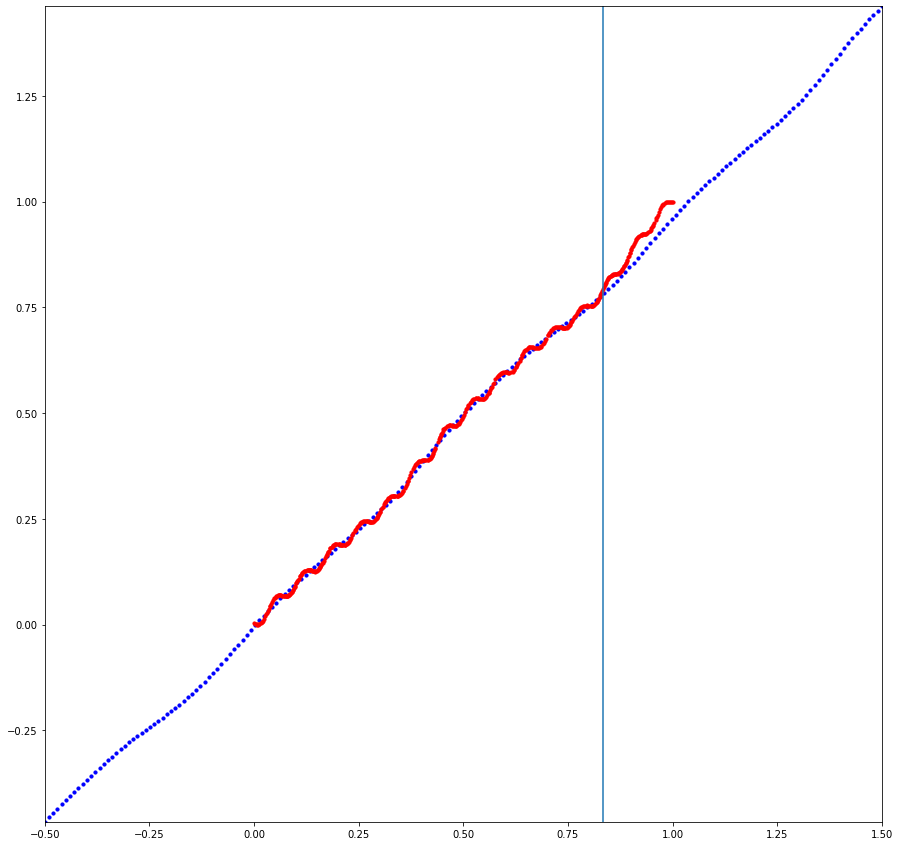

In [1685]:
kernel = ExpSineSquared(length_scale = 1, periodicity = 0.1, length_scale_bounds = (1E-3, 5E0),
                        periodicity_bounds = (1E-3, 1E0)) * C(0.1, (1e-3, 1e0)) \
        + DotProduct(sigma_0=1, sigma_0_bounds=(1e-03, 1e3))#*RBF(0.001, (1e-5, 1e2))#*C(1.0, (1e-3, 1e2))# \
#krreg = KernelRidge(alpha=1e-13, kernel=kernel, gamma='linear', degree=1, coef0=1, kernel_params=None)
#kernel = DotProduct(sigma_0=1, sigma_0_bounds=(1e-03, 1e3))
#kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))

gprn = GaussianProcessRegressor(kernel=kernel, alpha=1e-4, n_restarts_optimizer = 10, random_state=42)
# first extract linear behavior, then extract oscillatory pattern, forecast

X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
Xsub = dfdebreg[dfdebreg.datetimes < datfit].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

#X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

y = dfdebreg.loc[norads[oi_num]].n.values
ysub = dfdebreg[dfdebreg.datetimes < datfit].loc[norads[oi_num]].n.values

minmaxn = MinMaxScaler()
minmaxt = MinMaxScaler()
minmaxt.fit(X.reshape(-1, 1))
#minmaxn.fit(np.array([1,24]).reshape(-1, 1))
minmaxn.fit(y.reshape(-1, 1))
y = minmaxn.transform(y.reshape(-1, 1))
X = minmaxt.transform(X.reshape(-1, 1))
ysub = minmaxn.transform(ysub.reshape(-1, 1))
Xsub = minmaxt.transform(Xsub.reshape(-1, 1))
# first use linear to not overfit

#krreg = GaussianProcessRegressor(kernel=kernel, alpha=max(1e-10,0.1 * abs(y[1][0]- y[0][0])), n_restarts_optimizer = 10, random_state=42)

print(y[1][0]- y[0][0], y[1][0], y[0][0])

X_train, X_test, y_train, y_test = train_test_split(X, dfdebreg.loc[norads[oi_num]].n.values,
                                                    test_size=0.33, random_state=10)
#degree = 1
#poly_features = PolynomialFeatures(degree=degree)
#X_trainp = poly_features.fit_transform(X_train)
#X_testp = poly_features.fit_transform(X_test)
X_train = X
X_test = X
y_train = y
y_test = y
X_trainp = X_train
X_testp = X_test
X_testb = np.linspace(-0.5,1.5,200).reshape(-1,1)
print(len(X_trainp), len(y_train))
#krreg.fit(X_trainp, y_train)
gprn.fit(Xsub, ysub)

y_pred = gprn.predict(X_testb)
print(gprn.score(X, y))

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
plt.scatter(X_testb, y_pred, c = 'blue', s = 10)
plt.scatter(X_test, y_test, c = 'red', s = 10)
#print(krreg.params)
#krreg.

In [1562]:
#include tail fit

def fnreg(oi_num, dattaili = dattail, datfiti = datfit, addXY = False):
    kernel = ExpSineSquared(length_scale = 1, periodicity = 0.1, length_scale_bounds = (1E-3, 5E0),
                            periodicity_bounds = (1E-3, 1E1)) *  C(0.1, (1e-3, 2e0)) \
            + DotProduct(sigma_0=1, sigma_0_bounds=(1e-03, 1e3))

    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))


    X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub = dfdebreg[dfdebreg.datetimes < datfiti].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub2 = dfdebreg[(dfdebreg.datetimes < datfiti) & (dfdebreg.datetimes >= dattaili)].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub3 = dfdebreg[dfdebreg.datetimes < dattaili].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

    #X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

    y = dfdebreg.loc[norads[oi_num]].n.values
    ysub = dfdebreg[dfdebreg.datetimes < datfiti].loc[norads[oi_num]].n.values
    ysub2 = dfdebreg[(dfdebreg.datetimes < datfiti) & (dfdebreg.datetimes >= dattaili)].loc[norads[oi_num]].n.values
    ysub3 = dfdebreg[dfdebreg.datetimes < dattaili].loc[norads[oi_num]].n.values


    minmaxn = MinMaxScaler()
    minmaxt = MinMaxScaler()
    minmaxt.fit(X.reshape(-1, 1))
    #minmaxn.fit(np.array([1,24]).reshape(-1, 1))
    minmaxn.fit(y.reshape(-1, 1))
    y = minmaxn.transform(y.reshape(-1, 1))
    X = minmaxt.transform(X.reshape(-1, 1))
    ysub = minmaxn.transform(ysub.reshape(-1, 1))
    Xsub = minmaxt.transform(Xsub.reshape(-1, 1))
    ysub2 = minmaxn.transform(ysub2.reshape(-1, 1))
    Xsub2 = minmaxt.transform(Xsub2.reshape(-1, 1))
    ysub3 = minmaxn.transform(ysub3.reshape(-1, 1))
    Xsub3 = minmaxt.transform(Xsub3.reshape(-1, 1))

    alphaval = [1e-2,3e-2,1e-3,3e-3,1e-4,3e-4,1e-5,3e-5,1e-6,3e-6,1e-7,3e-7,1e-8,3e-8,1e-9,3e-9,1e-10]
    errlist = list()
    for a in alphaval:

        gprn = GaussianProcessRegressor(kernel=kernel, alpha=a, n_restarts_optimizer = 10, random_state=42)
        # first extract linear behavior, then extract oscillatory pattern, forecast
        gprn.fit(Xsub2, ysub2)
        #y_pred = gprn.predict(Xsub3)
        #errlist.append(mean_squared_error(ysub3, y_pred))
        errlist.append(gprn.score(Xsub3, ysub3))
        #gprn.fit(Xsub, ysub)
        #print(gprn.score(X, y))

    alpha = alphaval[np.argmax(errlist)]
    #alpha = alphaval[np.argmin(errlist)]
    print(alpha)
    print(errlist)

    # perform gradient descent
    def gprna(alphah):
        gprb = GaussianProcessRegressor(kernel=kernel, alpha=alphah, n_restarts_optimizer = 10, random_state=42)
        gprb.fit(Xsub2, ysub2)
        #y_pred = gprn.predict(Xsub3)
        #return mean_squared_error(ysub3, y_pred)
        return gprb.score(Xsub3, ysub3)

    boosting = False
    if boosting:
        alphan = alpha * 1.01
        g1 = (1 - gprna(alpha)) ** 2
        g2 = (1 - gprna(alphan)) ** 2
        g1 = gprna(alpha)
        g2 = gprna(alphan)
        igrad = (g1 - g2) / (alpha - alphan)
        if igrad != 0:
            basel = 0.05 * abs(alphan / (igrad))
            alphan = alpha
            alpha -= basel * igrad
            for i in range(5):
                g2 = g1
                g1 = (1 - gprna(alpha)) ** 2
                #g2 = (1 - gprna(alphan)) ** 2
                #g1 = gprna(alpha)
                #g2 = gprna(alphan)
                igrad = (g1 - g2) / (alpha - alphan)
                if igrad != 0:
                    alphan = alpha
                    alpha -= basel * igrad
                else: break


    #technically look for better alpha based on gradient boosting
    print(alpha)
    gprn = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer = 10, random_state=42)
    gprn.fit(Xsub, ysub)
    if addXY: return gprn, minmaxn, minmaxt, X, y
    return gprn, minmaxn, minmaxt

#X_test = np.linspace(-0.5,1.5,200).reshape(-1,1)
#y_pred = gprn.predict(X_test)
#print(gprn.score(X, y))

#print(r2_score(y_test, y_pred))

#ax = plt.figure(figsize = (15,15))
#lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
#plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
#plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
#plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
#plt.scatter(X, y, c = 'blue', s = 10)
#plt.scatter(X_test, y_pred, c = 'red', s = 10)
#print(krreg.params)
#krreg.

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  16.39665389, -371.37719451, -108.21448385,    0.99998452]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 8, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.02534340e+02, -1.52376944e+03, -2.49956032e+02,  1.00007171e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 86, 'nit': 7, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -19.78289927, -726.88651272,  -67.67151751,    1.00000538]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 78, 'nit': 7, 'warnflag': 2}

/U

0.001
[-0.9890715487302537, -0.8445862022988289, 0.8185607781829578, -1.001109283940628, 0.7286258373072008, 0.5048861658825332, -10.64929077252685, -9.402019539956154, -2.947110113426083, -2.5352208726097376, -5.620582783884163, -4.027291267490675, -3.8934724492804413, -6.217867207104196, -0.2907982701109775, -0.28819306016973134, -0.29727174440210646]
0.001
0.9964646356997422


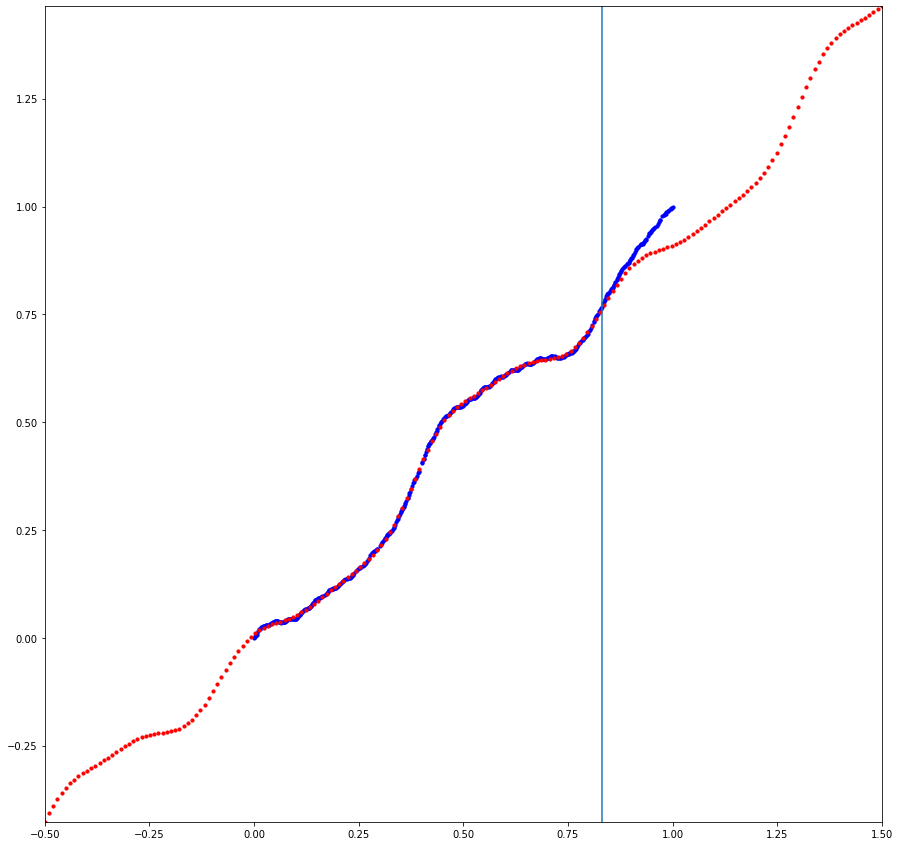

In [1563]:
gprn, minmaxn, minmaxt, X, y = fnreg(oi_num, addXY = True)
X_test = np.linspace(-0.5,1.5,200).reshape(-1,1)
y_pred = gprn.predict(X_test)
print(gprn.score(X, y))

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
plt.scatter(X, y, c = 'blue', s = 10)
plt.scatter(X_test, y_pred, c = 'red', s = 10)
#print(krreg.params)

In [1565]:
#include tail fit # eccentricity

def fereg(oi_num, dattaili = dattail, datfiti = datfit, addXY = False):
    kernel = ExpSineSquared(length_scale = 1, periodicity = 0.1, length_scale_bounds = (1E-3, 5E0),
                            periodicity_bounds = (1E-3, 1E1)) *  C(0.1, (1e-3, 2e0)) \
            + DotProduct(sigma_0=1, sigma_0_bounds=(1e-03, 1e3))

    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))


    X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub = dfdebreg[dfdebreg.datetimes < datfiti].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub2 = dfdebreg[(dfdebreg.datetimes < datfiti) & (dfdebreg.datetimes >= dattaili)].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub3 = dfdebreg[dfdebreg.datetimes < dattaili].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

    #X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

    y = dfdebreg.loc[norads[oi_num]].ecc.values
    ysub = dfdebreg[dfdebreg.datetimes < datfiti].loc[norads[oi_num]].ecc.values
    ysub2 = dfdebreg[(dfdebreg.datetimes < datfiti) & (dfdebreg.datetimes >= dattaili)].loc[norads[oi_num]].ecc.values
    ysub3 = dfdebreg[dfdebreg.datetimes < dattaili].loc[norads[oi_num]].ecc.values


    minmaxe = MinMaxScaler()
    minmaxt = MinMaxScaler()
    minmaxt.fit(X.reshape(-1, 1))
    #minmaxn.fit(np.array([1,24]).reshape(-1, 1))
    minmaxe.fit(y.reshape(-1, 1))
    y = minmaxe.transform(y.reshape(-1, 1))
    X = minmaxt.transform(X.reshape(-1, 1))
    ysub = minmaxe.transform(ysub.reshape(-1, 1))
    Xsub = minmaxt.transform(Xsub.reshape(-1, 1))
    ysub2 = minmaxe.transform(ysub2.reshape(-1, 1))
    Xsub2 = minmaxt.transform(Xsub2.reshape(-1, 1))
    ysub3 = minmaxe.transform(ysub3.reshape(-1, 1))
    Xsub3 = minmaxt.transform(Xsub3.reshape(-1, 1))

    alphaval = [1e-2,3e-2,1e-3,3e-3,1e-4,3e-4,1e-5,3e-5,1e-6,3e-6,1e-7,3e-7,1e-8,3e-8,1e-9,3e-9,1e-10]
    errlist = list()
    for a in alphaval:

        gpre = GaussianProcessRegressor(kernel=kernel, alpha=a, n_restarts_optimizer = 10, random_state=42)
        # first extract linear behavior, then extract oscillatory pattern, forecast
        gpre.fit(Xsub2, ysub2)
        #y_pred = gprn.predict(Xsub3)
        #errlist.append(mean_squared_error(ysub3, y_pred))
        errlist.append(gpre.score(Xsub3, ysub3))
        #gprn.fit(Xsub, ysub)
        #print(gprn.score(X, y))

    alpha = alphaval[np.argmax(errlist)]
    #alpha = alphaval[np.argmin(errlist)]

    #technically look for better alpha based on gradient boosting
    print(alpha)
    print(errlist)
    gpre = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer = 10, random_state=42)
    gpre.fit(Xsub, ysub)
    if addXY: return gpre, minmaxe, minmaxt, X, y
    return gpre, minmaxe, minmaxt

    
#X_test = np.linspace(-0.5,1.5,200).reshape(-1,1)
#y_pred = gpre.predict(X_test)
#print(gpre.score(X, y))

#print(r2_score(y_test, y_pred))

#ax = plt.figure(figsize = (15,15))
#lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
#plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
#plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
#plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
#plt.scatter(X, y, c = 'blue', s = 10)
#plt.scatter(X_test, y_pred, c = 'red', s = 10)
#print(krreg.params)
#krreg.

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-54.88331505, -59.02733293,  98.88082507,  -2.23896664]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 78, 'nit': 7, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -0.47742289, -19.26913668,   0.35642324,   1.07543945]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 129, 'nit': 18, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-215.13742049,   70.81855916,  -46.11055904,    0.98669434]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}

/Users/peterniks

3e-06
[0.4604612920796004, 0.6198477080428778, -7.661960497197887, 0.42822649277842784, -7.016090365535707, -7.8684192644551345, -5.315670633810369, -6.626864979188696, -4.967510547936613, 0.6933876382255338, -7.720190501046071, -0.288936145562547, -1.7928350100315344, -8.298372259163248, 0.28635117101499225, 0.2734565133667912, 0.29542449098774326]
0.9758447926642976


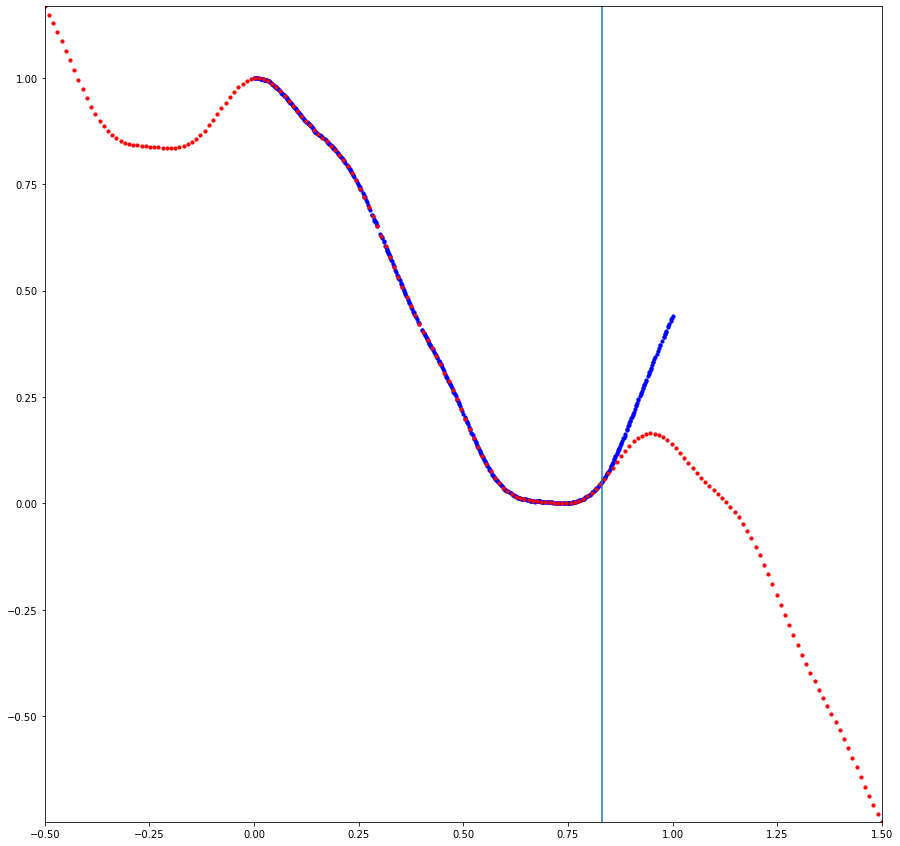

In [1566]:
gpre, minmaxe, minmaxt, X, y = fereg(oi_num, addXY = True)
X_test = np.linspace(-0.5,1.5,200).reshape(-1,1)
y_pred = gpre.predict(X_test)
print(gpre.score(X, y))

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
plt.scatter(X, y, c = 'blue', s = 10)
plt.scatter(X_test, y_pred, c = 'red', s = 10)
#print(krreg.params)
#krreg.

In [1567]:
#include tail fit # inclination

def fireg(oi_num, dattaili = dattail, datfiti = datfit, addXY = False):
    kernel = ExpSineSquared(length_scale = 1, periodicity = 0.1, length_scale_bounds = (1E-3, 5E0),
                            periodicity_bounds = (1E-3, 1E0)) *  C(0.1, (1e-3, 1e0)) \
            + DotProduct(sigma_0=0.01, sigma_0_bounds=(1e-05, 1e5))

    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))


    X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub = dfdebreg[dfdebreg.datetimes < datfiti].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub2 = dfdebreg[(dfdebreg.datetimes < datfiti) & (dfdebreg.datetimes >= dattaili)].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub3 = dfdebreg[dfdebreg.datetimes < dattaili].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

    #X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

    y = dfdebreg.loc[norads[oi_num]].inc.values
    ysub = dfdebreg[dfdebreg.datetimes < datfiti].loc[norads[oi_num]].inc.values
    ysub2 = dfdebreg[(dfdebreg.datetimes < datfiti) & (dfdebreg.datetimes >= dattaili)].loc[norads[oi_num]].inc.values
    ysub3 = dfdebreg[dfdebreg.datetimes < dattaili].loc[norads[oi_num]].inc.values


    minmaxi = MinMaxScaler()
    minmaxt = MinMaxScaler()
    minmaxt.fit(X.reshape(-1, 1))
    #minmaxn.fit(np.array([1,24]).reshape(-1, 1))
    minmaxi.fit(y.reshape(-1, 1))
    y = minmaxi.transform(y.reshape(-1, 1))
    X = minmaxt.transform(X.reshape(-1, 1))
    ysub = minmaxi.transform(ysub.reshape(-1, 1))
    Xsub = minmaxt.transform(Xsub.reshape(-1, 1))
    ysub2 = minmaxi.transform(ysub2.reshape(-1, 1))
    Xsub2 = minmaxt.transform(Xsub2.reshape(-1, 1))
    ysub3 = minmaxi.transform(ysub3.reshape(-1, 1))
    Xsub3 = minmaxt.transform(Xsub3.reshape(-1, 1))

    alphaval = [1e-2,3e-2,1e-3,3e-3,1e-4,3e-4,1e-5,3e-5,1e-6,3e-6,1e-7,3e-7,1e-8,3e-8,1e-9,3e-9,1e-10]
    errlist = list()
    for a in alphaval:
    #    break
        gpri = GaussianProcessRegressor(kernel=kernel, alpha=a, n_restarts_optimizer = 10, random_state=42)
        # first extract linear behavior, then extract oscillatory pattern, forecast
        gpri.fit(Xsub2, ysub2)
     #   y_pred = gprn.predict(Xsub3)
    #    errlist.append(mean_squared_error(ysub3, y_pred))
        errlist.append(gpri.score(Xsub3, ysub3))
        #gprn.fit(Xsub, ysub)
        #print(gprn.score(X, y))
    alpha = alphaval[np.argmax(errlist)]

    #alpha = alphaval[np.argmin(errlist)]
    #alpha = 1e-2

    #technically look for better alpha based on gradient boosting
    print(alpha)
    print(errlist)
    gpri = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer = 10, random_state=42)
    gpri.fit(Xsub, ysub)
    if addXY: return gpri, minmaxi, minmaxt, X, y
    return gpri, minmaxi, minmaxt

#X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
#y_pred = gpri.predict(X_test)
#print(gpri.score(X, y))

#print(r2_score(y_test, y_pred))

#ax = plt.figure(figsize = (15,15))
#lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
#plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
#plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
#plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
#plt.scatter(X, y, c = 'blue', s = 10)
#plt.scatter(X_test, y_pred, c = 'red', s = 10)
#print(krreg.params)
#krreg.

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.25556682,  0.22392286, -0.17077596,  0.99265289]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 9, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([3.05121014e+02, 7.95657501e+08, 1.70761366e+01, 1.82693481e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 3, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.79652863e+04,  1.88201275e+07, -1.98881131e+04,  3.44162598e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 4, 'warnflag': 2}

/Users

0.03
[-0.7449939248669522, 0.6756860202360646, -1.3133003263362153, -1.0222945525113065, -0.42276317558101484, -0.43852482398833725, -1.4017112088945258, -0.6478856810854352, -2.148347626974372, -2.165422246929444, -2.134221996413472, -5.011107583229648, -1.620251354784798, -2.1169655083325307, -1.6202635559712233, -1.6202606189614297, -1.6201478914286191]


/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -9.95638526,  17.02748415, -37.31874643,   0.99991369]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 147, 'nit': 17, 'warnflag': 2}



0.7805105902770579


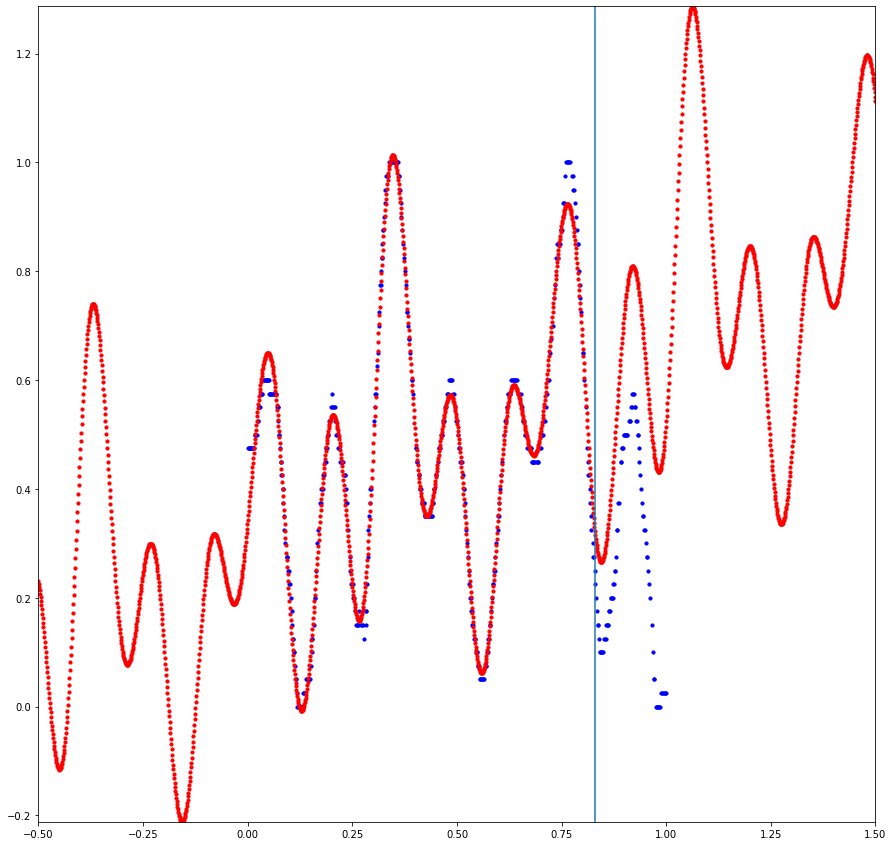

In [1568]:
gpri, minmaxi, minmaxt, X, y = fireg(oi_num, addXY = True)
X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
y_pred = gpri.predict(X_test)
print(gpri.score(X, y))

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
plt.scatter(X, y, c = 'blue', s = 10)
plt.scatter(X_test, y_pred, c = 'red', s = 10)
#print(krreg.params)
#krreg.

In [1569]:
#raan fit

def frreg(oi_num, dattaili = dattail, datfiti = datfit, addXY = False):
    # first fit base behavior then fit submodel
    ## perform curve_fit for raan
    fitfunc = lambda x, p0, p1: (p0 + p1 * x) #% 1
    # sortby datetime
    dfsub = dfdebreg.loc[norads[oi_num]].sort_values('datetimes')
    X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    X = dfsub.datetimes.apply(lambda x: x.timestamp()).values


    #X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)
    y = dfdebreg.loc[norads[oi_num]].raan.values
    y = dfsub.raan.values

    minmaxr = MinMaxScaler()
    minmaxt = MinMaxScaler()
    minmaxt.fit(X.reshape(-1, 1))
    minmaxr.fit(np.array([0,360]).reshape(-1, 1))
    y = minmaxr.transform(y.reshape(-1, 1))
    X = minmaxt.transform(X.reshape(-1, 1))

    # now split different regions according to distance
    boundt = 0.7 ** 2
    regions = list()#np.empty(shape = [9,2])#array()#(2,1)
    #print(regions.shape)
    sign = 1
    yc = y[0]
    for i, x in enumerate(X): # problem X is not ordered
        if(i > 0):
            dx = X[i] - X[i - 1]
            dy = y[i] - y[i - 1]
            dist = (dx ** 2 + dy ** 2)
            if dist > boundt: # do something
                print('doing', i, dist, X[i])
                #regions[i] = [X[i - 1], X[i]]
                #np.append(regions, [X[i - 1], X[i]], axis = 0)
                regions.append([X[i - 1], X[i], sign])
                yc = y[i]
            #elif dy <= 0: sign = -1 #can fail
            #else: sign = 1 
            if(y[i] - yc >= 0): sign = 1
            else: sign = -1
    Xreg = X
    ilower = 0;
    #count = 1
    for c in regions:
        for i in range(ilower, len(X)):
            if X[i] > c[0]:
                #Xreg.append
                y[i] += c[2]
                #count += c[2] 
                #pass

    # Assume sign remains constant
    #print(X[:,0])
    ymod = minmaxr.inverse_transform(y)

    #print(ymod)
    dfdebreg.loc[norads[oi_num],'raanmod'] = ymod




    kernel = ExpSineSquared(length_scale = 1, periodicity = 0.1, length_scale_bounds = (1E-7, 5E0),
                            periodicity_bounds = (1E-3, 1E1)) *  C(0.0001, (1e-8, 1e-3)) \
            + DotProduct(sigma_0=1, sigma_0_bounds=(1e-03, 1e3))
    #kernel = DotProduct(sigma_0=1, sigma_0_bounds=(1e-03, 1e3))
    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))


    #X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub = list()#dfdebreg[dfdebreg.datetimes < datfit].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub2 = list()#dfdebreg[(dfdebreg.datetimes < datfit) & (dfdebreg.datetimes >= dattail)].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub3 = list()#dfdebreg[dfdebreg.datetimes < dattail].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

    #X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

    #y = dfdebreg.loc[norads[oi_num]].inc.values
    ysub = list()#dfdebreg[dfdebreg.datetimes < datfit].loc[norads[oi_num]].inc.values
    ysub2 = list()#dfdebreg[(dfdebreg.datetimes < datfit) & (dfdebreg.datetimes >= dattail)].loc[norads[oi_num]].inc.values
    ysub3 = list()#dfdebreg[dfdebreg.datetimes < dattail].loc[norads[oi_num]].inc.values

    dfit = minmaxt.transform(np.array(datfiti.timestamp()).reshape(-1,1))[0][0]
    dtail = minmaxt.transform(np.array(dattaili.timestamp()).reshape(-1,1))[0][0]

    for idx, x in enumerate(X):
        if x < dfit:
            Xsub.append(x)
            ysub.append(y[idx])
            #print(ysub[idx], y[idx])
        if x < dfit and x >= dtail:
            Xsub2.append(x)
            ysub2.append(y[idx])
        if x < dtail:
            Xsub3.append(x)
            ysub3.append(y[idx])


    #print(ysub2)
    #print(datfit.timestamp(), dattail.timestamp())

    #minmaxi = MinMaxScaler()
    #minmaxt = MinMaxScaler()
    #minmaxt.fit(X.reshape(-1, 1))
    #minmaxn.fit(np.array([1,24]).reshape(-1, 1))
    #minmaxi.fit(y.reshape(-1, 1))
    #y = minmaxi.transform(y.reshape(-1, 1))
    #X = minmaxt.transform(X.reshape(-1, 1))
    ysub = np.array(ysub)
    ysub2 = np.array(ysub2)
    ysub3 = np.array(ysub3)
    Xsub = np.array(Xsub)
    Xsub2 = np.array(Xsub2)
    Xsub3 = np.array(Xsub3)
    #ysub = minmaxi.transform(ysub.reshape(-1, 1))
    #Xsub = minmaxt.transform(Xsub.reshape(-1, 1))
    #ysub2 = minmaxi.transform(ysub2.reshape(-1, 1))
    #Xsub2 = minmaxt.transform(Xsub2.reshape(-1, 1))
    #ysub3 = minmaxi.transform(ysub3.reshape(-1, 1))
    #Xsub3 = minmaxt.transform(Xsub3.reshape(-1, 1))

    alphaval = [1e-2,3e-2,1e-3,3e-3,1e-4,3e-4,1e-5,3e-5,1e-6,3e-6,1e-7,3e-7,1e-8,3e-8,1e-9,3e-9,1e-10]
    errlist = list()
    for a in alphaval:
    #    break
        gprr = GaussianProcessRegressor(kernel=kernel, alpha=a, n_restarts_optimizer = 10, random_state=42)
        # first extract linear behavior, then extract oscillatory pattern, forecast
        gprr.fit(Xsub2, ysub2)
     #   y_pred = gprn.predict(Xsub3)
    #    errlist.append(mean_squared_error(ysub3, y_pred))
        errlist.append(gprr.score(Xsub3, ysub3))
        #gprn.fit(Xsub, ysub)
        #print(gprn.score(X, y))
    alpha = alphaval[np.argmax(errlist)]

    #alpha = alphaval[np.argmin(errlist)]
    #alpha = 1e-2

    #technically look for better alpha based on gradient boosting
    print(alpha)
    print(errlist)
    gprr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer = 10, random_state=42)
    gprr.fit(Xsub, ysub)
    if addXY: return gprr, minmaxr, minmaxt, X, y
    return gprr, minmaxr, minmaxt
#X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
#y_pred = gprr.predict(X_test)
#y_predc = gprr.predict(X)
#print(gprr.score(X, y))

#print(r2_score(y_test, y_pred))

#ax = plt.figure(figsize = (15,15))
#lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
#plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
#plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
#plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
#plt.scatter(X, y, c = 'blue', s = 1)
#plt.scatter(X_test, y_pred, c = 'red', s = 1)
#plt.ylim(np.min(y_predc - y),np.max(y_predc - y))
#plt.scatter(X, y_predc - y, c = 'red', s = 10)
#print(krreg.params)
#krreg.


#print(X)
#print(y_pred)
#print(ysub)
#print(y)











#X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1), y,
#                                                    test_size=0.33, random_state=42)
#init = [1,-3]
#out2, cov_x2 = curve_fit(fitfunc, xdata = X_train.flatten(), ydata = y_train.flatten(), p0 = init)

#degree = 1
#poly_features = PolynomialFeatures(degree=degree)
#X_trainp = poly_features.fit_transform(X_train)
#X_testp = poly_features.fit_transform(X_test)
#print(out2)
#y_pred2 = fitfunc(X, out2[0], out2[1])
#plt.scatter(X, y_pred2 - y, c = 'blue')



#print(out2)

#y_pred = fitfunc(X_testp, out2[0], out2[1])
#krreg.fit(X_trainp[:,1].reshape(-1,1), y_train)

#y_pred = krreg.predict(X_testp)

#better  
#print(r2_score(y_test, y_pred))

#ax = plt.figure(figsize = (15,15))
#plt.xlim(0.,1.)
#plt.ylim(np.min(y_test),np.max(y_test))
#plt.ylim(np.min(y_pred2 - y),np.max(y_pred2 - y))
#plt.ylim(-6,6)
#plt.scatter(X_test, y_test.flatten(), c = 'red')
#plt.scatter(X_testp[:, 1], y_pred[:, 1], c = 'blue')
#plt.scatter(X, y, c = 'red')
#y_train
#X_testp
#X_testp[:, 1]
#y_pred[:,1]
#regions
#y_test
#X_test
#regions
#y_pred

doing 216 [0.98625067] [0.36412192]
doing 426 [0.98625122] [0.75869283]


/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00000000e+00, -0.00000000e+00,  1.73237084e+00, -1.58704701e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.        , -0.        , 94.27744541,  1.2734375 ]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 2, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.85252474e-01, -1.03926204e+07,  1.73934003e+02, -3.36678593e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}

/U

3e-06
[0.9999219175982313, 0.9992984661693668, 0.9999992233634621, 0.9999929789758087, 0.9999999925695834, 0.9999999311253537, 0.9999999998011797, 0.9999999992894856, 0.9999999998272332, 0.999999999832302, 0.9999999998228591, 0.9999999998239495, 0.9999999998221867, 0.9999999998224238, 0.9999999998204433, 0.9999999998217133, 0.9999999992446025]
0.9999999999298665


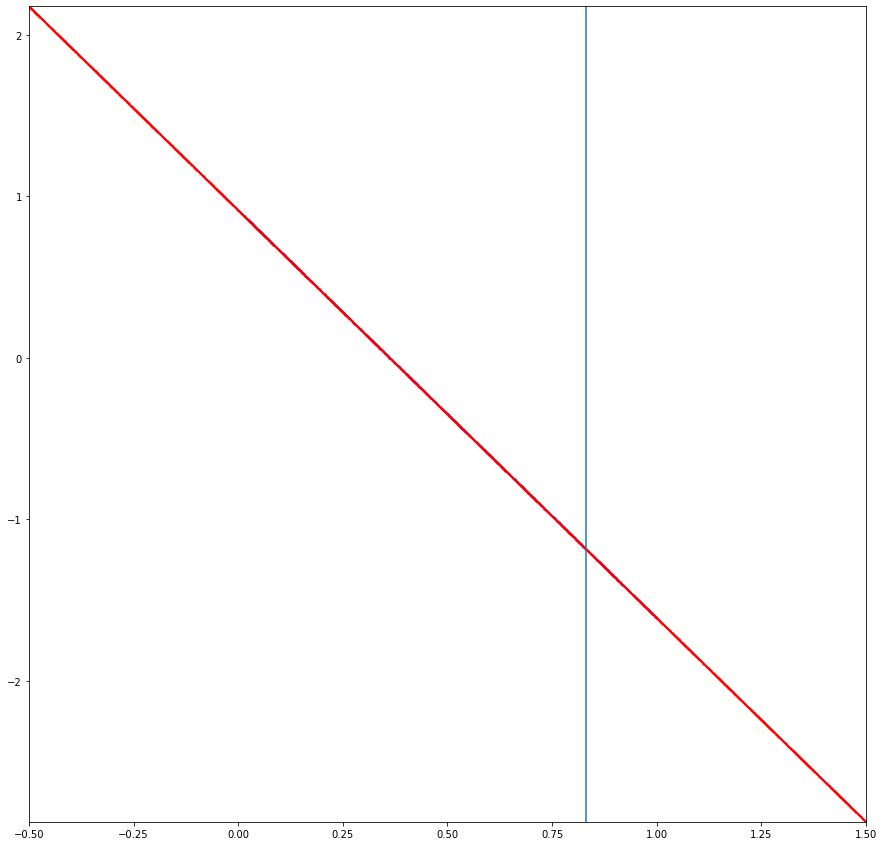

In [1570]:
gprr, minmaxr, minmaxt, X, y = frreg(oi_num, addXY = True)
X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
y_pred = gprr.predict(X_test)
y_predc = gprr.predict(X)
print(gprr.score(X, y))

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
plt.scatter(X, y, c = 'blue', s = 1)
plt.scatter(X_test, y_pred, c = 'red', s = 1)

In [1573]:
#argp fit
def fareg(oi_num, dattaili = dattail, datfiti = datfit, addXY = False):

    # first fit base behavior then fit submodel
    ## perform curve_fit for argp
    fitfunc = lambda x, p0, p1: (p0 + p1 * x) #% 1
    # sortby datetime
    dfsub = dfdebreg.loc[norads[oi_num]].sort_values('datetimes')
    X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    X = dfsub.datetimes.apply(lambda x: x.timestamp()).values


    #X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)
    y = dfdebreg.loc[norads[oi_num]].argp.values
    y = dfsub.argp.values

    minmaxa = MinMaxScaler()
    minmaxt = MinMaxScaler()
    minmaxt.fit(X.reshape(-1, 1))
    minmaxa.fit(np.array([0,360]).reshape(-1, 1))
    y = minmaxa.transform(y.reshape(-1, 1))
    X = minmaxt.transform(X.reshape(-1, 1))

    # now split different regions according to distance
    boundt = 0.7 ** 2
    regions = list()#np.empty(shape = [9,2])#array()#(2,1)
    #print(regions.shape)
    sign = 1
    yc = y[0]
    for i, x in enumerate(X): # problem X is not ordered
        if(i > 0):
            dx = X[i] - X[i - 1]
            dy = y[i] - y[i - 1]
            dist = (dx ** 2 + dy ** 2)
            if dist > boundt: # do something
                print('doing', i, dist, X[i])
                #regions[i] = [X[i - 1], X[i]]
                #np.append(regions, [X[i - 1], X[i]], axis = 0)
                regions.append([X[i - 1], X[i], sign])
                yc = y[i]
            #elif dy <= 0: sign = -1 #can fail
            #else: sign = 1 
            if(y[i] - yc >= 0): sign = 1
            else: sign = -1
    Xreg = X
    ilower = 0;
    #count = 1
    for c in regions:
        for i in range(ilower, len(X)):
            if X[i] > c[0]:
                #Xreg.append
                y[i] += c[2]
                #count += c[2] 
                #pass

    # Assume sign remains constant
    #print(X[:,0])
    ymod = minmaxa.inverse_transform(y)

    #print(ymod)
    dfdebreg.loc[norads[oi_num],'argpmod'] = ymod




    kernel = ExpSineSquared(length_scale = 1, periodicity = 0.1, length_scale_bounds = (1E-3, 5E0),
                            periodicity_bounds = (1E-3, 1E1)) *  C(0.01, (1e-8, 1e-0)) \
            + DotProduct(sigma_0=1, sigma_0_bounds=(1e-03, 1e3))
    #kernel = DotProduct(sigma_0=1, sigma_0_bounds=(1e-03, 1e3))
    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))


    #X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub = list()#dfdebreg[dfdebreg.datetimes < datfit].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub2 = list()#dfdebreg[(dfdebreg.datetimes < datfit) & (dfdebreg.datetimes >= dattail)].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub3 = list()#dfdebreg[dfdebreg.datetimes < dattail].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

    #X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

    #y = dfdebreg.loc[norads[oi_num]].inc.values
    ysub = list()#dfdebreg[dfdebreg.datetimes < datfit].loc[norads[oi_num]].inc.values
    ysub2 = list()#dfdebreg[(dfdebreg.datetimes < datfit) & (dfdebreg.datetimes >= dattail)].loc[norads[oi_num]].inc.values
    ysub3 = list()#dfdebreg[dfdebreg.datetimes < dattail].loc[norads[oi_num]].inc.values

    dfit = minmaxt.transform(np.array(datfiti.timestamp()).reshape(-1,1))[0][0]
    dtail = minmaxt.transform(np.array(dattaili.timestamp()).reshape(-1,1))[0][0]

    for idx, x in enumerate(X):
        if x < dfit:
            Xsub.append(x)
            ysub.append(y[idx])
            #print(ysub[idx], y[idx])
        if x < dfit and x >= dtail:
            Xsub2.append(x)
            ysub2.append(y[idx])
        if x < dtail:
            Xsub3.append(x)
            ysub3.append(y[idx])


    #print(ysub2)
    #print(datfit.timestamp(), dattail.timestamp())

    #minmaxi = MinMaxScaler()
    #minmaxt = MinMaxScaler()
    #minmaxt.fit(X.reshape(-1, 1))
    #minmaxn.fit(np.array([1,24]).reshape(-1, 1))
    #minmaxi.fit(y.reshape(-1, 1))
    #y = minmaxi.transform(y.reshape(-1, 1))
    #X = minmaxt.transform(X.reshape(-1, 1))
    ysub = np.array(ysub)
    ysub2 = np.array(ysub2)
    ysub3 = np.array(ysub3)
    Xsub = np.array(Xsub)
    Xsub2 = np.array(Xsub2)
    Xsub3 = np.array(Xsub3)
    #ysub = minmaxi.transform(ysub.reshape(-1, 1))
    #Xsub = minmaxt.transform(Xsub.reshape(-1, 1))
    #ysub2 = minmaxi.transform(ysub2.reshape(-1, 1))
    #Xsub2 = minmaxt.transform(Xsub2.reshape(-1, 1))
    #ysub3 = minmaxi.transform(ysub3.reshape(-1, 1))
    #Xsub3 = minmaxt.transform(Xsub3.reshape(-1, 1))

    alphaval = [1e-2,3e-2,1e-3,3e-3,1e-4,3e-4,1e-5,3e-5,1e-6,3e-6,1e-7,3e-7,1e-8,3e-8,1e-9,3e-9,1e-10]
    errlist = list()
    for a in alphaval:
    #    break
        gpra = GaussianProcessRegressor(kernel=kernel, alpha=a, n_restarts_optimizer = 10, random_state=42)
        # first extract linear behavior, then extract oscillatory pattern, forecast
        gpra.fit(Xsub2, ysub2)
     #   y_pred = gprn.predict(Xsub3)
    #    errlist.append(mean_squared_error(ysub3, y_pred))
        errlist.append(gpra.score(Xsub3, ysub3))
        #gprn.fit(Xsub, ysub)
        #print(gprn.score(X, y))
    alpha = alphaval[np.argmax(errlist)]

    #alpha = alphaval[np.argmin(errlist)]
    #alpha = 1e-2

    #technically look for better alpha based on gradient boosting
    print(alpha)
    print(errlist)
    gpra = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer = 10, random_state=42)
    gpra.fit(Xsub, ysub)
    if addXY: return gpra, minmaxa, minmaxt, X, y
    return gpra, minmaxa, minmaxt
#X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
#y_pred = gpra.predict(X_test)
#y_predc = gpra.predict(X)
#print(gpra.score(X, y))

#print(r2_score(y_test, y_pred))

#ax = plt.figure(figsize = (15,15))
#lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
#plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
#plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
#plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
#plt.scatter(X, y, c = 'blue', s = 1)
#plt.scatter(X_test, y_pred, c = 'red', s = 1)
#plt.ylim(np.min(y_predc - y),np.max(y_predc - y))
#plt.scatter(X, y_predc - y, c = 'red', s = 10)
#print(krreg.params)
#krreg.


#print(X)
#print(y_pred)
#print(ysub)
#print(y)











#X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1), y,
#                                                    test_size=0.33, random_state=42)
#init = [1,-3]
#out2, cov_x2 = curve_fit(fitfunc, xdata = X_train.flatten(), ydata = y_train.flatten(), p0 = init)

#degree = 1
#poly_features = PolynomialFeatures(degree=degree)
#X_trainp = poly_features.fit_transform(X_train)
#X_testp = poly_features.fit_transform(X_test)
#print(out2)
#y_pred2 = fitfunc(X, out2[0], out2[1])
#plt.scatter(X, y_pred2 - y, c = 'blue')



#print(out2)

#y_pred = fitfunc(X_testp, out2[0], out2[1])
#krreg.fit(X_trainp[:,1].reshape(-1,1), y_train)

#y_pred = krreg.predict(X_testp)

#better  
#print(r2_score(y_test, y_pred))

#ax = plt.figure(figsize = (15,15))
#plt.xlim(0.,1.)
#plt.ylim(np.min(y_test),np.max(y_test))
#plt.ylim(np.min(y_pred2 - y),np.max(y_pred2 - y))
#plt.ylim(-6,6)
#plt.scatter(X_test, y_test.flatten(), c = 'red')
#plt.scatter(X_testp[:, 1], y_pred[:, 1], c = 'blue')
#plt.scatter(X, y, c = 'red')
#y_train
#X_testp
#X_testp[:, 1]
#y_pred[:,1]
#regions
#y_test
#X_test
#regions
#y_pred

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.02389882, 38.04124643, -0.53754787,  1.04858398]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 3, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.11906235e+01,  1.58960151e+08, -2.75855243e+00,  1.04394531e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 7, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.47093985e+03,  2.82431556e+03, -4.51842478e+02, -2.34951182e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 6, 'warnflag': 2}

/U

0.0003
[0.9156557353669917, 0.8941364248207592, 0.9969217578185239, 0.977386078392048, 0.9990602217879972, 0.9995699595856549, 0.9938431369131269, 0.9970991731280778, 0.9755671135695831, 0.9868477534648853, 0.9786353595629962, 0.9750861160940665, 0.9832990616035232, 0.9815310800451891, 0.9849044414921885, 0.9849213627454971, 0.8758368944162507]
0.9998062144433064


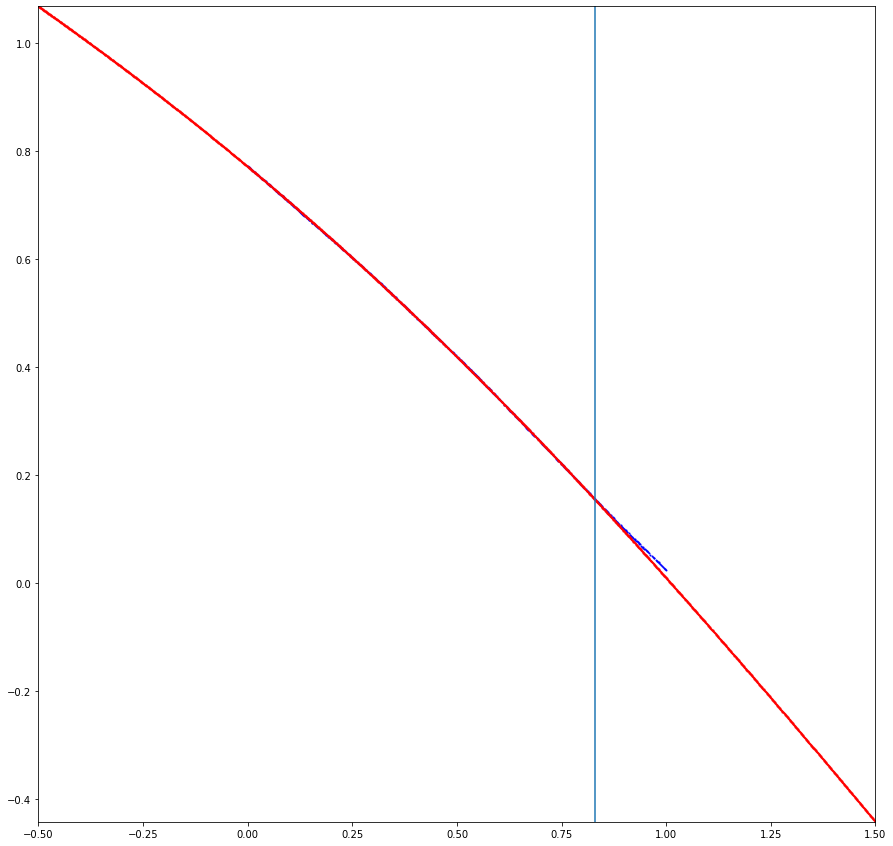

In [1574]:
gpra, minmaxa, minmaxt, X, y = fareg(oi_num, addXY = True)
X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
y_pred = gpra.predict(X_test)
y_predc = gpra.predict(X)
print(gpra.score(X, y))

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
plt.scatter(X, y, c = 'blue', s = 1)
plt.scatter(X_test, y_pred, c = 'red', s = 1)
#plt.ylim(np.min(y_predc - y),np.max(y_predc - y))
#plt.scatter(X, y_predc - y, c = 'red', s = 10)
#print(krreg.params)
#krreg.

In [ ]:
# now model m using simple baseline model and study fluctuations

In [1432]:
import scipy.integrate as integrate

In [1433]:
def nfunc(t):
    #t = minmaxt.inverse_transform(t)
    return minmaxn.inverse_transform(gprn.predict(np.array(t).reshape(1,-1)))[0][0]

In [1434]:
print(dfdebreg.loc[norads[oi_num]].tail(1).argp.values[0])
print(dfdebreg.loc[norads[oi_num]].head(1).argp.values[0])

8.7973
278.1332


In [1435]:
print(dfdebreg.loc[norads[oi_num]].tail(1).raan.values[0])
print(dfdebreg.loc[norads[oi_num]].head(1).raan.values[0])

139.9626
329.0796


In [1436]:
dfdebreg.loc[norads[oi_num]].tail(1).head(1).m.values[0]

351.4386

In [1437]:
te = minmaxt.transform(np.array([dfdebreg.loc[norads[oi_num]].tail(1).head(1).datetimes.values[0].timestamp()]).reshape(1,-1))

In [1438]:
# mean anomaly (m) calc
# integrate 360 * n over time n in terms of sec is n = n'/(24*3600)   gprn
# int n'(t)/240 dt, minmaxn, minmaxt
delt = minmaxt.inverse_transform(np.array([0,1]).reshape(1,-1))[0]
delt = delt[1] - delt[0]
t = 1
print(integrate.quad(nfunc, 0, te)[1] / 240 * delt)
(integrate.quad(nfunc, 0, te)[0] / 240 * delt + dfdebreg.loc[norads[oi_num]].m.values[0]) % 360
#dfdebreg.loc[norads[oi_num]].m.values[0]
#nfunc(0)
#minmaxn.inverse_transform(np.array([0,1]).reshape(1,-1))[0][1]

1.2206592956786815e-05


350.3608817467466

In [1459]:
#X[:,0]
ymm = [(integrate.quad(nfunc, 0, x)[0] / 240 * delt + dfdebreg.loc[norads[oi_num]].m.values[0]) % 360 for x in X]

In [1583]:
#include tail fit # m

def fmreg(oi_num, minmaxt, dattaili = dattail, datfiti = datfit, addXY = False):
    kernel = ExpSineSquared(length_scale = 1, periodicity = 0.01, length_scale_bounds = (1E-3, 5E1),
                            periodicity_bounds = (1E-3, 1E0)) *  C(0.1, (1e-4, 1e0)) \
            + DotProduct(sigma_0=1, sigma_0_bounds=(1e-05, 1e5))

    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))


    X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub = dfdebreg[dfdebreg.datetimes < datfit].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub2 = dfdebreg[(dfdebreg.datetimes < datfit) & (dfdebreg.datetimes >= dattail)].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub3 = dfdebreg[dfdebreg.datetimes < dattail].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

    #X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

    y = dfdebreg.loc[norads[oi_num]].m.values
    ysub = dfdebreg[dfdebreg.datetimes < datfit].loc[norads[oi_num]].m.values
    ysub2 = dfdebreg[(dfdebreg.datetimes < datfit) & (dfdebreg.datetimes >= dattail)].loc[norads[oi_num]].m.values
    ysub3 = dfdebreg[dfdebreg.datetimes < dattail].loc[norads[oi_num]].m.values


    delt = minmaxt.inverse_transform(np.array([0,1]).reshape(1,-1))[0]
    delt = delt[1] - delt[0]
    #t = 1
    #print(integrate.quad(nfunc, 0, te)[1] / 240 * delt)
    #X[:,0]
    ymm = np.array([(integrate.quad(nfunc, 0, x)[0] / 240 * delt + dfdebreg.loc[norads[oi_num]].m.values[0]) % 360 for x in X]).reshape(1,-1)
    ymms = np.array([(integrate.quad(nfunc, 0, x)[0] / 240 * delt + dfdebreg.loc[norads[oi_num]].m.values[0]) % 360 for x in Xsub]).reshape(1,-1)
    ymms2 = np.array([(integrate.quad(nfunc, 0, x)[0] / 240 * delt + dfdebreg.loc[norads[oi_num]].m.values[0]) % 360 for x in Xsub2]).reshape(1,-1)
    ymms3 = np.array([(integrate.quad(nfunc, 0, x)[0] / 240 * delt + dfdebreg.loc[norads[oi_num]].m.values[0]) % 360 for x in Xsub3]).reshape(1,-1)

    # take into account fluctuations about 0 and 360
    yh = y - ymm
    yhs = ysub - ymms
    yhs2 = ysub2 - ymms2
    yhs3 = ysub3 - ymms3
    for idx, xi in np.ndenumerate(yh):
        if xi > 180: yh[idx] = xi - 360 
        elif xi < -180: yh[idx] = xi + 360 
    for idx, xi in np.ndenumerate(yhs):
        if xi > 180: yhs[idx] = xi - 360 
        elif xi < -180: yhs[idx] = xi + 360 
    for idx, xi in np.ndenumerate(yhs2):
        if xi > 180: yhs2[idx] = xi - 360 
        elif xi < -180: yhs2[idx] = xi + 360 
    for idx, xi in np.ndenumerate(yhs3):
        if xi > 180: yhs3[idx] = xi - 360 
        elif xi < -180: yhs3[idx] = xi + 360 

    minmaxm = MinMaxScaler()
    minmaxt = MinMaxScaler()
    minmaxt.fit(X.reshape(-1, 1))
    #minmaxn.fit(np.array([1,24]).reshape(-1, 1))
    minmaxm.fit(yh.reshape(-1, 1))
    yh = minmaxm.transform(yh.reshape(-1, 1))
    X = minmaxt.transform(X.reshape(-1, 1))
    yhs = minmaxm.transform(yhs.reshape(-1, 1))
    Xsub = minmaxt.transform(Xsub.reshape(-1, 1))
    yhs2 = minmaxm.transform(yhs2.reshape(-1, 1))
    Xsub2 = minmaxt.transform(Xsub2.reshape(-1, 1))
    yhs3 = minmaxm.transform(yhs3.reshape(-1, 1))
    Xsub3 = minmaxt.transform(Xsub3.reshape(-1, 1))

    alphaval = [1e-2,3e-2,1e-3,3e-3,1e-4,3e-4,1e-5,3e-5,1e-6,3e-6,1e-7,3e-7,1e-8,3e-8,1e-9,3e-9,1e-10]
    errlist = list()
    for a in alphaval:
    #    break
        gprm = GaussianProcessRegressor(kernel=kernel, alpha=a, n_restarts_optimizer = 10, random_state=42)
        # first extract linear behavior, then extract oscillatory pattern, forecast
        gprm.fit(Xsub2, yhs2)
        #y_pred = gprm.predict(Xsub3)
        #errlist.append(mean_squared_error(yhs3, y_pred))
        errlist.append(gprm.score(Xsub3, yhs3))
        #gprn.fit(Xsub, ysub)
        #print(gprn.score(X, y))
    alpha = alphaval[np.argmax(errlist)]

    #alpha = alphaval[np.argmin(errlist)]
    #alpha = 1e-2

    #technically look for better alpha based on gradient boosting
    print(alpha)
    print(errlist)
    gprm = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer = 10, random_state=42)
    gprm.fit(Xsub, yhs)
    if addXY: return gprm, minmaxm, X, yh
    return gprm, minmaxm
#X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
#y_pred = gprm.predict(X_test)
#print(gprm.score(X, yh))

#print(r2_score(y_test, y_pred))

#ax = plt.figure(figsize = (15,15))
#lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
#plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
#plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
#plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
#plt.scatter(X, yh, c = 'blue', s = 10)
#plt.scatter(X_test, y_pred, c = 'red', s = 10)
#print(krreg.params)
#krreg.

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.40743399e+01,  1.71731252e+06, -1.49098824e+00,  9.49279785e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.60360251e+01, -4.29547822e+03,  1.20602446e-02,  1.00000522e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 202, 'nit': 38, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.42633767e-01, -5.71315225e+01,  1.46067070e-02,  1.01876831e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 95, 'nit': 13,

0.001
[-0.09564862783665284, -0.08949811761863802, -0.04899306958463079, -0.14586428087316006, -0.13632710062800335, -0.16894846741322866, -0.21807199565701518, -0.20927365835060918, -0.09887456414074447, -0.04985391378348236, -0.17290105712267811, -0.25613043551565573, -0.21463122696521664, -0.11359526927748065, -2.169462185728864, -0.08174470630677022, -2.415939056253542]


/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 9.50243500e+01,  6.26282283e+05, -1.22976965e+01,  1.01861572e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 164, 'nit': 28, 'warnflag': 2}



0.8086621122039385


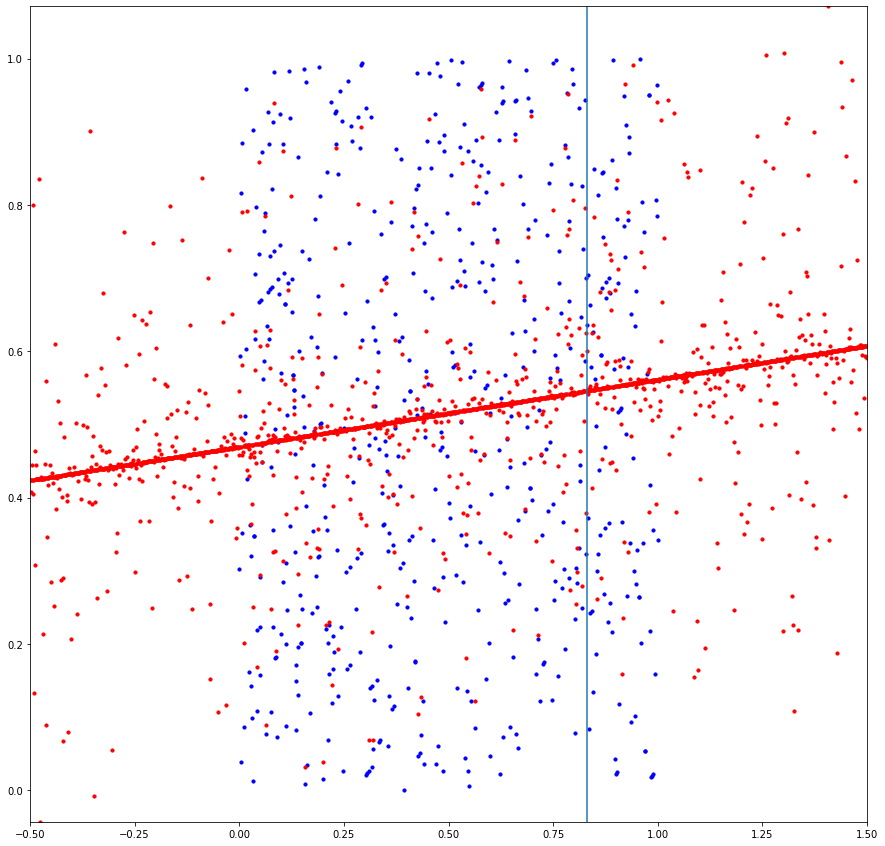

In [1584]:
gprm, minmaxm, X, yh = fmreg(oi_num, minmaxt = minmaxt, addXY = True)
X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
y_pred = gprm.predict(X_test)
print(gprm.score(X, yh))

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
plt.scatter(X, yh, c = 'blue', s = 10)
plt.scatter(X_test, y_pred, c = 'red', s = 10)

In [1622]:
def mpred(Xin, minmaxm, gprm):
    return np.add(minmaxm.inverse_transform(gprm.predict(Xin)), \
            np.array([(integrate.quad(nfunc, 0, x)[0] / 240 * delt \
                       + dfdebreg.loc[norads[oi_num]].m.values[0]) for x in Xin]).reshape(len(Xin),-1)) % 360
            #+ integrate.quad(nfunc, 0, Xin)[0] / 240 * delt \
            #+ dfdebreg.loc[norads[oi_num]].m.values[0]) % 360

In [1620]:
Xl = [1,0.5,0]
Xan = np.array(Xl).reshape(len(Xl),-1)
#mpred(Xan, gprm = gprm, minmaxm = minmaxm)[:,0]
#np.array([1,0.5]).reshape(2,-1)
#minmaxm.inverse_transform(gprm.predict(Xan))
np.array([(integrate.quad(nfunc, 0, x)[0] / 240 * delt \
                       + dfdebreg.loc[norads[oi_num]].m.values[0]) for x in Xan]).reshape(len(Xan),-1) 
#Xan

array([[1.84426810e+06],
       [9.22163443e+05],
       [8.10546000e+01]])

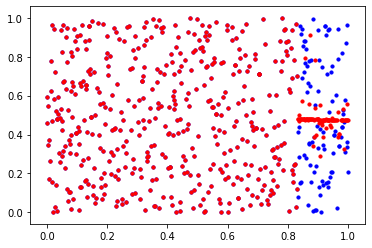

In [1554]:
plt.scatter(X, yh, c = 'blue', s = 10)
y_pred11 = gprm.predict(X)
plt.scatter(X, y_pred11, c = 'red', s = 10)

In [1528]:
dfdebreg.head()

m     argp     bstar     dn_o2       ecc      inc  \
norad date                                                                    
119   2018.916314  270.3322  90.8959  0.000116  0.000002  0.009762  66.7291   
      2018.918618  270.9942  90.2340  0.000132  0.000002  0.009762  66.7292   
      2018.920538  271.5473  89.6810  0.000139  0.000002  0.009764  66.7292   
      2018.921690  271.8807  89.3476  0.000145  0.000003  0.009765  66.7292   
      2018.924762  272.7554  88.4725  0.000146  0.000003  0.009766  66.7293   

                           n      raan                   datetimes  \
norad date                                                           
119   2018.916314  14.231530  321.6569  2018-12-02 08:54:00.447264   
      2018.918618  14.231535  319.4778  2018-12-03 05:08:23.052480   
      2018.920538  14.231539  317.6620  2018-12-03 22:00:21.864672   
      2018.921690  14.231542  316.5724  2018-12-04 08:07:33.134016   
      2018.924762  14.231550  313.6672  2018-12-05 11:06:43.134336   

                             x            y            z  raanmod  argpmod  
norad date                                                                  
119   2018.916314  1193.468954  5280.337957 -4805.947471      NaN      NaN  
      2018.918618   273.176198  6514.606535 -3177.855333      NaN      NaN  
      2018.920538  -136.651913  6858.366053 -2371.102905      NaN      NaN  
      2018.921690  -530.784596  7073.827005 -1549.948503      NaN      NaN  
      2018.924762  -550.232623  7081.356831 -1509.005731      NaN      NaN

In [1585]:
#include tail fit # bstar

def fbreg(oi_num, dattaili = dattail, datfiti = datfit, addXY = False):
    kernel = ExpSineSquared(length_scale = 1, periodicity = 0.01, length_scale_bounds = (1E-3, 5E1),
                            periodicity_bounds = (1E-3, 1E0)) *  C(0.1, (1e-3, 1e0)) \
            + DotProduct(sigma_0=1, sigma_0_bounds=(1e-05, 1e5))

    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))


    X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub = dfdebreg[dfdebreg.datetimes < datfiti].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub2 = dfdebreg[(dfdebreg.datetimes < datfiti) & (dfdebreg.datetimes >= dattaili)].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub3 = dfdebreg[dfdebreg.datetimes < dattaili].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

    #X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

    y = dfdebreg.loc[norads[oi_num]].bstar.values
    ysub = dfdebreg[dfdebreg.datetimes < datfiti].loc[norads[oi_num]].bstar.values
    ysub2 = dfdebreg[(dfdebreg.datetimes < datfiti) & (dfdebreg.datetimes >= dattaili)].loc[norads[oi_num]].bstar.values
    ysub3 = dfdebreg[dfdebreg.datetimes < dattaili].loc[norads[oi_num]].bstar.values


    minmaxb = MinMaxScaler()
    minmaxt = MinMaxScaler()
    minmaxt.fit(X.reshape(-1, 1))
    #minmaxn.fit(np.array([1,24]).reshape(-1, 1))
    minmaxb.fit(y.reshape(-1, 1))
    y = minmaxb.transform(y.reshape(-1, 1))
    X = minmaxt.transform(X.reshape(-1, 1))
    ysub = minmaxb.transform(ysub.reshape(-1, 1))
    Xsub = minmaxt.transform(Xsub.reshape(-1, 1))
    ysub2 = minmaxb.transform(ysub2.reshape(-1, 1))
    Xsub2 = minmaxt.transform(Xsub2.reshape(-1, 1))
    ysub3 = minmaxb.transform(ysub3.reshape(-1, 1))
    Xsub3 = minmaxt.transform(Xsub3.reshape(-1, 1))

    alphaval = [1e-2,3e-2,1e-3,3e-3,1e-4,3e-4,1e-5,3e-5,1e-6,3e-6,1e-7,3e-7,1e-8,3e-8,1e-9,3e-9,1e-10]
    errlist = list()
    for a in alphaval:
    #    break
        gprb = GaussianProcessRegressor(kernel=kernel, alpha=a, n_restarts_optimizer = 10, random_state=42)
        # first extract linear behavior, then extract oscillatory pattern, forecast
        gprb.fit(Xsub2, ysub2)
    #    y_pred = gprb.predict(Xsub3)
    #    errlist.append(mean_squared_error(ysub3, y_pred))
        errlist.append(gprb.score(Xsub3, ysub3))
        #gprn.fit(Xsub, ysub)
        #print(gprn.score(X, y))
    alpha = alphaval[np.argmax(errlist)]

    #alpha = alphaval[np.argmin(errlist)]
    #alpha = 1e-2

    #technically look for better alpha based on gradient boosting
    print(alpha)
    print(errlist)
    gprb = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer = 10, random_state=42)
    gprb.fit(Xsub, ysub)
    if addXY: return gprb, minmaxb, X, y
    return gprb, minmaxb
#X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
#y_pred = gprb.predict(X_test)
#print(gprb.score(X, y))

#print(r2_score(y_test, y_pred))

#ax = plt.figure(figsize = (15,15))
#lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
#plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
#plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
#plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
#plt.scatter(X, y, c = 'blue', s = 10)
#plt.scatter(X_test, y_pred, c = 'red', s = 10)
#print(krreg.params)
#krreg.

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  0.85593149, -14.89518548,  -0.18410068,   1.06524658]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 89, 'nit': 25, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.2857919 ,  0.62680654, -7.49250639,  1.00016665]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 4, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.46106960e+00, -8.42964077e+04, -1.61348072e+03,  1.05712891e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 6, 'warnflag': 2}

/Users/petern

0.003
[-0.27582671892738886, -0.48117105674425925, -0.0878087427925287, -0.06682914152689223, -1.2370104340524506, -0.5666117310908605, -0.5368267595189156, -0.40745477252480367, -2.925752366211109, -2.6720313887728047, -3.1764852056391124, -2.343198220851854, -1.458959657338939, -2.757576802179082, -1.4636028996975134, -0.816715320432938, -2.5774782831559686]
0.8988302931658059


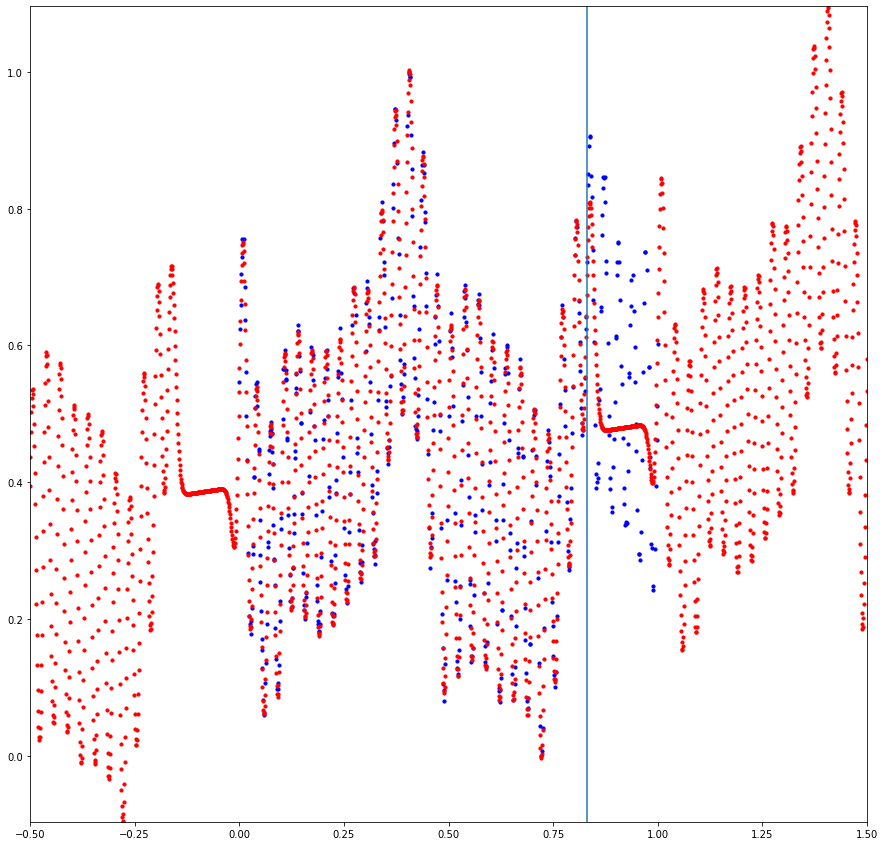

In [1586]:
gprb, minmaxb, X, y = fbreg(oi_num, addXY = True)
X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
y_pred = gprb.predict(X_test)
print(gprb.score(X, y))

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
plt.scatter(X, y, c = 'blue', s = 10)
plt.scatter(X_test, y_pred, c = 'red', s = 10)

In [1587]:
#include tail fit # dn_o2

def fdreg(oi_num, dattaili = dattail, datfiti = datfit, addXY = False):
    kernel = ExpSineSquared(length_scale = 1, periodicity = 0.01, length_scale_bounds = (1E-4, 5E1),
                            periodicity_bounds = (1E-4, 1E0)) *  C(0.1, (1e-3, 1e0)) \
            + DotProduct(sigma_0=1, sigma_0_bounds=(1e-03, 1e3))

    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))


    X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub = dfdebreg[dfdebreg.datetimes < datfiti].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub2 = dfdebreg[(dfdebreg.datetimes < datfiti) & (dfdebreg.datetimes >= dattaili)].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub3 = dfdebreg[dfdebreg.datetimes < dattaili].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

    #X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

    y = dfdebreg.loc[norads[oi_num]].dn_o2.values
    ysub = dfdebreg[dfdebreg.datetimes < datfiti].loc[norads[oi_num]].dn_o2.values
    ysub2 = dfdebreg[(dfdebreg.datetimes < datfiti) & (dfdebreg.datetimes >= dattaili)].loc[norads[oi_num]].dn_o2.values
    ysub3 = dfdebreg[dfdebreg.datetimes < dattaili].loc[norads[oi_num]].dn_o2.values


    minmaxdn = MinMaxScaler()
    minmaxt = MinMaxScaler()
    minmaxt.fit(X.reshape(-1, 1))
    #minmaxn.fit(np.array([1,24]).reshape(-1, 1))
    minmaxdn.fit(y.reshape(-1, 1))
    y = minmaxdn.transform(y.reshape(-1, 1))
    X = minmaxt.transform(X.reshape(-1, 1))
    ysub = minmaxdn.transform(ysub.reshape(-1, 1))
    Xsub = minmaxt.transform(Xsub.reshape(-1, 1))
    ysub2 = minmaxdn.transform(ysub2.reshape(-1, 1))
    Xsub2 = minmaxt.transform(Xsub2.reshape(-1, 1))
    ysub3 = minmaxdn.transform(ysub3.reshape(-1, 1))
    Xsub3 = minmaxt.transform(Xsub3.reshape(-1, 1))

    alphaval = [1e-2,3e-2,1e-3,3e-3,1e-4,3e-4,1e-5,3e-5,1e-6,3e-6,1e-7,3e-7,1e-8,3e-8,1e-9,3e-9,1e-10]
    errlist = list()
    for a in alphaval:
    #    break
        gprdn = GaussianProcessRegressor(kernel=kernel, alpha=a, n_restarts_optimizer = 10, random_state=42)
        # first extract linear behavior, then extract oscillatory pattern, forecast
        gprdn.fit(Xsub2, ysub2)
      #  y_pred = gprdn.predict(Xsub3)
      #  errlist.append(mean_squared_error(ysub3, y_pred))
        errlist.append(gprdn.score(Xsub3, ysub3))
        #gprn.fit(Xsub, ysub)
        #print(gprn.score(X, y))
    alpha = alphaval[np.argmax(errlist)]

    #alpha = alphaval[np.argmin(errlist)]
    #alpha = 1e-2

    #technically look for better alpha based on gradient boosting
    print(alpha)
    print(errlist)
    gprdn = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer = 10, random_state=42)
    gprdn.fit(Xsub, ysub)
    if addXY: return gprdn, minmaxdn, X, y
    return gprdn, minmaxdn
#X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
#y_pred = gprdn.predict(X_test)
#print(gprdn.score(X, y))

#print(r2_score(y_test, y_pred))

#ax = plt.figure(figsize = (15,15))
#lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
#plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
#plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
#plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
#plt.scatter(X, y, c = 'blue', s = 10)
#plt.scatter(X_test, y_pred, c = 'red', s = 10)
#print(krreg.params)
#krreg.

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -0.12495205, -45.79241267,  34.43430527,   1.00000562]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 141, 'nit': 25, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([36.65128817,  1.45290986, 41.45105834,  0.99999455]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 101, 'nit': 9, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.12996897e+00,  1.24691820e+04,  2.31600402e+00,  9.99964912e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 175, 'nit': 55, 'warnflag': 2}

/Users/pe

0.003
[-1.9463710181684757, -0.6337809295102101, -0.08983192471575174, -0.06583919823302753, -1.2463657219105015, -0.5781055713057903, -1.3296048513801717, -0.4231947278593144, -1.2993228670048773, -1.9745898242932731, -0.807987487231317, -1.8981571073751642, -0.8085927049111996, -0.8084859568039493, -0.8086438391960662, -2.9895558501511723, -1.848799065409335]
0.8991470539227718


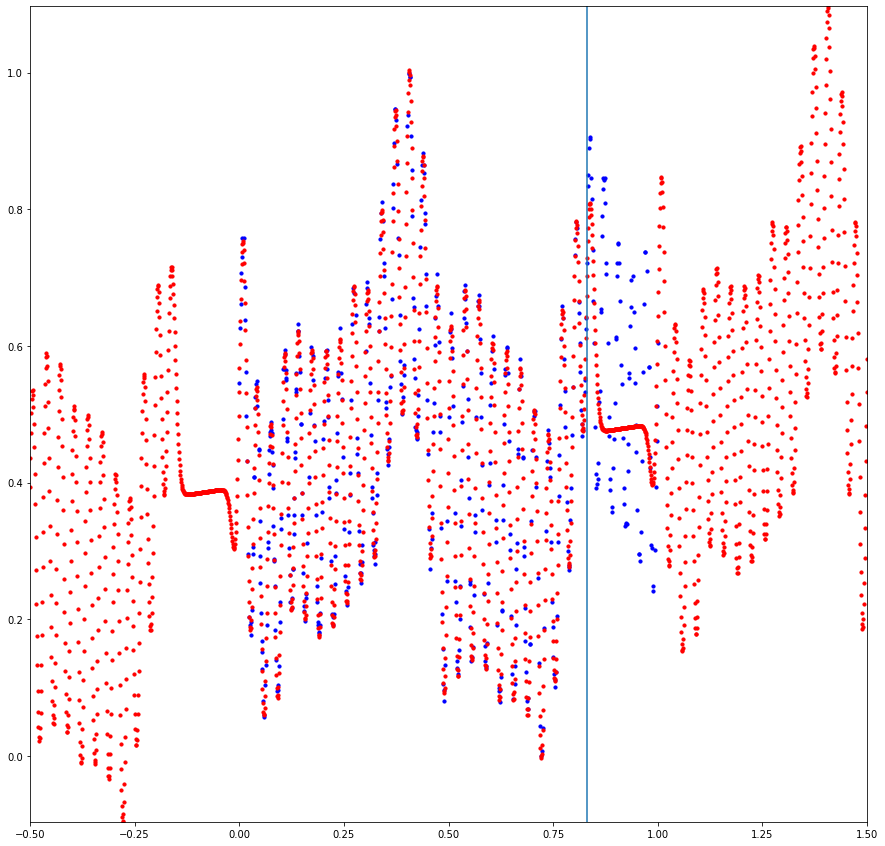

In [1588]:
gprdn, minmaxdn, X, y = fdreg(oi_num, addXY = True)
X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
y_pred = gprdn.predict(X_test)
print(gprdn.score(X, y))

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
plt.scatter(X, y, c = 'blue', s = 10)
plt.scatter(X_test, y_pred, c = 'red', s = 10)

In [ ]:
# now sort out all important quanities and develop class, adjust line1, line2 params

In [1627]:
class oi_predictor:
    def __init__(self, oi):
        gprn, minmaxn, minmaxt = fnreg(oi)
        gpre, minmaxe, minmaxt = fereg(oi)
        gpri, minmaxi, minmaxt = fireg(oi)
        gprr, minmaxr, minmaxt = frreg(oi)
        gpra, minmaxa, minmaxt = fareg(oi)
        gprm, minmaxm = fmreg(oi, minmaxt = minmaxt) # use mpred(Xin, minmaxm, gprm)
        gprb, minmaxb = fbreg(oi)
        gprdn, minmaxdn = fdreg(oi)
    def predict(self, X):
        return minmaxn.inverse_transform(gprn.predict(X)), minmaxe.inverse_transform(gpre.predict(X)), \
            minmaxi.inverse_transform(gpri.predict(X)), minmaxr.inverse_transform(gprr.predict(X)) % 360,\
            minmaxa.inverse_transform(gpra.predict(X)) % 360, mpred(X, minmaxm, gprm) % 360,\
            minmaxb.inverse_transform(gprb.predict(X)), minmaxdn.inverse_transform(gprdn.predict(X))

In [1628]:
oi_pred = oi_predictor(oi_num)

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  16.39665389, -371.37719451, -108.21448385,    0.99998452]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 8, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.02534340e+02, -1.52376944e+03, -2.49956032e+02,  1.00007171e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 86, 'nit': 7, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -19.78289927, -726.88651272,  -67.67151751,    1.00000538]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 78, 'nit': 7, 'warnflag': 2}

/U

0.001
[-0.9890715487302537, -0.8445862022988289, 0.8185607781829578, -1.001109283940628, 0.7286258373072008, 0.5048861658825332, -10.64930977089761, -9.402019539956154, -2.946909354094948, -2.5352208726097376, -5.620582783884163, -4.027291267490675, -3.8929694744050005, -6.217926984607008, -0.2907982701109775, -0.28817690095345494, -0.29727174440210646]
0.001


/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-54.88331505, -59.02733293,  98.88082507,  -2.23896664]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 78, 'nit': 7, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -0.47742289, -19.26913668,   0.35642324,   1.07543945]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 129, 'nit': 18, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-215.13742049,   70.81855916,  -46.11055904,    0.98669434]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}

/Users/peterniks

3e-06
[0.4604612920797754, 0.6198477080428778, -7.661960497147992, 0.42822649277842784, -7.016070731597511, -7.8684192644551345, -5.315727098164814, -6.6268649300293525, -4.967510547936613, 0.693369236856185, -7.720190501046071, -0.288936145562547, -1.7928350100315344, -8.29836131595541, 0.28635117101499225, 0.2734563200341031, 0.29542449098774326]


/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.80804796, -1.30695823,  0.33471217,  0.99799728]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 12, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([3.05121014e+02, 7.95657501e+08, 1.70761366e+01, 1.82693481e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 3, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([369.34784281, 369.6843923 ,  45.69543587,   1.00384136]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 8, 'warnflag': 2}

/Users/peterniksa

0.03
[-0.7449938857493025, 0.6756860202360646, -1.3133003263369947, -1.0222945525228648, -0.422764505104281, -0.43852482398833725, -1.4017099649322589, -0.6478761584912429, -2.148311243735192, -2.1654043577607673, -4.995670280331026, -5.011107583229648, -1.6202513547308346, -2.1169655083325307, -1.6202635559712233, -1.6202606189614297, -1.6201517565221253]


/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -9.95638526,  17.02748415, -37.31874643,   0.99991369]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 147, 'nit': 17, 'warnflag': 2}



doing 216 [0.98625067] [0.36412192]
doing 426 [0.98625122] [0.75869283]


/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00000000e+00, -0.00000000e+00,  1.73237084e+00, -1.58704701e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.        , -0.        , 94.27744541,  1.2734375 ]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 2, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.85252474e-01, -1.03926204e+07,  1.73934003e+02, -3.36678593e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}

/U

3e-06
[0.9999219175982313, 0.9992984661693668, 0.9999992233634621, 0.9999929789758089, 0.9999999925695834, 0.9999999311253537, 0.9999999998011797, 0.9999999992894856, 0.9999999998272332, 0.999999999832302, 0.9999999998228591, 0.9999999998239495, 0.9999999998221871, 0.9999999998224238, 0.9999999998204433, 0.9999999998217133, 0.9999999991818656]


/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.02389882, 38.04124643, -0.53754787,  1.04858398]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 3, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.11906235e+01,  1.58960151e+08, -2.75855243e+00,  1.04394531e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 7, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.47093985e+03,  2.82431556e+03, -4.51842478e+02, -2.34951182e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 6, 'warnflag': 2}

/U

0.0003
[0.9156557353669917, 0.8941364248207592, 0.9969217578185239, 0.977386078392048, 0.9990602217879972, 0.9995699595856549, 0.9938431369131269, 0.9970991731280778, 0.9755671135695831, 0.9868477534648853, 0.9786353595629962, 0.9750861160940665, 0.9832990616035232, 0.9815310800451891, 0.9849044414921885, 0.9849213627454971, 0.8758368944162507]


/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.40743399e+01,  1.71731252e+06, -1.49098824e+00,  9.49279785e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.60360251e+01, -4.29547822e+03,  1.20602446e-02,  1.00000522e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 202, 'nit': 38, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.42633767e-01, -5.71315225e+01,  1.46067070e-02,  1.01876831e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 95, 'nit': 13,

0.001
[-0.09564862783665284, -0.08949811761863802, -0.04899306958463079, -0.14586428087316006, -0.13632710062800335, -0.16894846741322866, -0.21807199565701518, -0.20927365835060918, -0.09887456414074447, -0.04985391378348236, -0.17290105712267811, -0.25613043551565573, -0.21463122696521664, -0.11359526927748065, -2.169462185728864, -0.08174470630677022, -2.415939056253542]


/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 9.50243500e+01,  6.26282283e+05, -1.22976965e+01,  1.01861572e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 164, 'nit': 28, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  0.85593149, -14.89518548,  -0.18410068,   1.06524658]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 89, 'nit': 25, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.45607601e+00, -8.47036717e+04, -1.61350799e+03,  9.51843262e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 79, 'nit': 7, 'warnflag':

0.003
[-0.27582671892738886, -0.48117105674844884, -0.08780878643657108, -0.06682914152689223, -1.2370104340524506, -0.5666100574938053, -0.5368267595189156, -0.4074394495337783, -3.199053894786556, -2.6720313887728047, -3.1764852056391124, -2.343198220851854, -1.458959657338939, -2.757576802179082, -1.4636028996975134, -0.816715320432938, -3.5157463296356175]


/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -0.12495205, -45.79241267,  34.43430527,   1.00000562]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 141, 'nit': 25, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([36.65128817,  1.45290986, 41.45105834,  0.99999455]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 101, 'nit': 9, 'warnflag': 2}

/Users/peterniksa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.12996897e+00,  1.24691820e+04,  2.31600402e+00,  9.99964912e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 175, 'nit': 55, 'warnflag': 2}

/Users/pe

0.003
[-1.9463710181684757, -0.6337809295102101, -0.08983192471575174, -0.06583919823302753, -1.2463657219105015, -0.5781055713057903, -1.3296048513801717, -0.4231947278593144, -1.2993228670048773, -1.9745898242932731, -0.807987487231317, -1.8981571073751642, -0.8085927049111996, -0.8084859568039493, -0.8086438391960662, -2.9895558501511723, -1.848799065409335]


In [1596]:
-278-360 % 360

-278

In [1629]:
oi_pred.predict(X)

(array([[14.05420297],
        [14.05420397],
        [14.05420446],
        [14.05420532],
        [14.05420597],
        [14.0542066 ],
        [14.05420781],
        [14.05420896],
        [14.05420927],
        [14.05421005],
        [14.05421057],
        [14.05421108],
        [14.05421205],
        [14.05421304],
        [14.0542133 ],
        [14.05421398],
        [14.05421422],
        [14.05421475],
        [14.05421543],
        [14.0542156 ],
        [14.0542163 ],
        [14.0542163 ],
        [14.05421707],
        [14.05421722],
        [14.05421776],
        [14.05421828],
        [14.05421842],
        [14.05421902],
        [14.05421907],
        [14.0542197 ],
        [14.05421988],
        [14.0542201 ],
        [14.05422032],
        [14.05422071],
        [14.05422079],
        [14.05422092],
        [14.05422139],
        [14.05422191],
        [14.05422208],
        [14.05422268],
        [14.0542229 ],
        [14.05422333],
        [14.0542239 ],
        [14

In [1623]:
# X needs to be transformed
minmaxn.inverse_transform(gprn.predict(X)), minmaxe.inverse_transform(gpre.predict(X)), \
            minmaxi.inverse_transform(gpri.predict(X)), minmaxr.inverse_transform(gprr.predict(X)) % 360,\
            minmaxa.inverse_transform(gpra.predict(X)) % 360, mpred(X, minmaxm, gprm) % 360,\
            minmaxb.inverse_transform(gprb.predict(X)), minmaxdn.inverse_transform(gprdn.predict(X))

(array([[14.05420297],
        [14.05420397],
        [14.05420446],
        [14.05420532],
        [14.05420597],
        [14.0542066 ],
        [14.05420781],
        [14.05420896],
        [14.05420927],
        [14.05421005],
        [14.05421057],
        [14.05421108],
        [14.05421205],
        [14.05421304],
        [14.0542133 ],
        [14.05421398],
        [14.05421422],
        [14.05421475],
        [14.05421543],
        [14.0542156 ],
        [14.0542163 ],
        [14.0542163 ],
        [14.05421707],
        [14.05421722],
        [14.05421776],
        [14.05421828],
        [14.05421842],
        [14.05421902],
        [14.05421907],
        [14.0542197 ],
        [14.05421988],
        [14.0542201 ],
        [14.05422032],
        [14.05422071],
        [14.05422079],
        [14.05422092],
        [14.05422139],
        [14.05422191],
        [14.05422208],
        [14.05422268],
        [14.0542229 ],
        [14.05422333],
        [14.0542239 ],
        [14

In [1626]:
mpred(X, minmaxm, gprm) % 360 # need to adjust mpred

array([[1.04961247e+01],
       [1.14545202e+02],
       [1.94065795e+02],
       [2.78365302e+02],
       [2.19327417e+02],
       [3.03719568e+01],
       [2.96914757e+02],
       [8.05211142e+01],
       [8.92696459e+01],
       [2.43459623e+02],
       [1.22713141e+02],
       [5.95584566e+01],
       [7.67373799e+01],
       [3.27583029e+02],
       [3.87519015e+01],
       [3.21155007e+02],
       [2.47514134e+01],
       [3.06628146e+02],
       [2.28197383e+02],
       [2.76402260e+02],
       [3.60272562e+01],
       [3.60272562e+01],
       [1.32602051e+02],
       [1.70713174e+02],
       [1.97200396e+02],
       [3.52830920e+02],
       [3.13619826e+02],
       [1.52578966e+02],
       [1.77011969e+02],
       [3.55880984e+02],
       [3.32570552e+02],
       [2.04858767e+01],
       [1.55314212e+02],
       [7.71900106e+01],
       [2.27513165e+02],
       [8.55757333e+01],
       [1.18269826e+02],
       [1.27355715e+02],
       [1.90970671e+02],
       [2.00258111e+02],


In [ ]:
#generate lines l1, l2

In [1635]:
def isnumeric(x):
    try: 
        float(x)
        return True
    except:
        return False

In [1639]:
print(isnumeric('a'), isnumeric('1'), isnumeric('.'), isnumeric('+'), isnumeric(' '))

False True False False False


In [1644]:
ltest = '1     5U 58002B   19292.92671750 +.00000171 +00000-0 +22506-3 0  9997'

def checksum(line):
    csum = 0
    for x in range(len(line) - 1):
        if isnumeric(line[x]):
            csum += int(line[x])
        if line[x] == '-': csum += 1
    return csum % 10

In [1692]:
def setsign(inputa):
    inputa = str(inputa)
    if float(inputa) < 0: return ''
    else: return '+'

In [1656]:
checksum(ltest)
ltest[18:20]

'19'

In [1658]:
str(datetime.fromtimestamp(minmaxt.inverse_transform(X)[-1,0]).year)[-2:]

'19'

In [1687]:
datetime.fromtimestamp(minmaxt.inverse_transform(X)[-1,0])

datetime.datetime(2019, 11, 30, 18, 27, 33, 554880)

In [1674]:
print(dfdeb_m.head().line1.values)
dfdeb_m.head().bstar.values

['1 00119U 61015D   18335.37083851 +.00000192 +00000-0 +11600-3 0  9992'
 '1 00119U 61015D   18336.21415570 +.00000230 +00000-0 +13189-3 0  9990'
 '1 00119U 61015D   18336.91691973 +.00000246 +00000-0 +13881-3 0  9996'
 '1 00119U 61015D   18337.33857794 +.00000262 +00000-0 +14544-3 0  9993'
 '1 00119U 61015D   18338.46299924 +.00000263 +00000-0 +14575-3 0  9998']


array([0.000116  , 0.00013189, 0.00013881, 0.00014544, 0.00014575])

In [1682]:
tap = 0.000116
ntap = math.ceil(np.log(tap) / np.log(10))
str(tap)[2 - ntap:]

'116'

In [1669]:
a = datetime.fromtimestamp(minmaxt.inverse_transform(X)[-1,0]) - datetime(year = datetime.fromtimestamp(minmaxt.inverse_transform(X)[-1,0]).year, month = 1, day = 1)
days = a.days + a.seconds / (3600 * 24) + a.microseconds / (3600 * 24 * 1000 * 1000)
days
#a


334.6734266166667

In [1739]:
ltest = '1     5U 58002B   19292.92671750 +.00000171 +00000-0 +22506-3 0  9997'
# given old line1 and line2, produce new for time x

# params as n, ecc, inc, raan, argp, m, bstar, dn_o2
# extract year from time and perform timedelta in days
def line1gen_new(line1, params, time): # time as datetime
    #line1 modify range wise
    
    #19-20 year digits
    #21-32 day 3 . 8 digits
    #34-43 dn_o2 sign . 8 digits
    #45-52 dn_o6 sign 5 digits - mag
    #54-61 bstar sign 5 digits - mag
    #69 checksum of string
    linelist = [x for x in line1]
    linelist[18:20] = str(time.year)[-2:]
    daytime = time - datetime(year = time.year, month = 1, day = 1)
    days = (daytime.days + (daytime.seconds + daytime.microseconds / 1e6) / (3600 * 24))
    # technically insufficient
    daysd = str(int(days - days % 1))
    while len(daysd) < 3: daysd = '0' + daysd
    days = daysd + str(float(days % 1))[1:]
    while len(daysd) < 12: daysd += '0'
    linelist[20:32] = str(days)[:12]
    dno2s = setsign(params[7]) + str(params[7])[1:]
    while len(dno2s) < 10: dno2s += '0'
    linelist[33:43] = dno2s
    bstars = params[6]
    ntap = 0
    if(bstars > 0):
        ntap = math.ceil(np.log(bstars) / np.log(10))
    digitstr = str(bstars)[2 - ntap:]
    bstarsstr = str(bstars)
    while len(digitstr) < 5: digitstr += '0'
    linelist[53:61] = setsign(bstars) + digitstr + str(ntap)
    line1 = ""
    for x in linelist:
        line1 += x
    csum = checksum(line1)
    linelist[68] = str(csum)
    line1 = ""
    for x in linelist:
        line1 += x
    return line1

#line1 = ('1 00005U 58002B   00179.78495062  '
#         '.00000023  00000-0  28098-4 0  4753')
#1     5U 58002B   19292.92671750 +.00000171 +00000-0 +22506-3 0  9997

In [1740]:
params = [14, 0.1, 10, 100, 130, 76, 0.000134, 0.0001267]
time = datetime.fromtimestamp(minmaxt.inverse_transform(X)[-1,0])
print(line1gen_new(ltest, params, time))
print(ltest)

1     5U 58002B   19333.76913836 +.00012670 +00000-0 +13400-3 0  9999
1     5U 58002B   19292.92671750 +.00000171 +00000-0 +22506-3 0  9997


In [1741]:
ltest2 = '2     5 034.2474 252.3331 1842730 345.5028 009.8881 10.84775502179024'

# params as n, ecc, inc, raan, argp, m, bstar, dn_o2
def line2gen_new(line2, params, time):
    #linelist = [x for x in line1]
    #line1 = ""
    #for x in linelist:
    #    line1 += x
    
    #9-16 inc 3.4
    #18-25 raan 3.4
    #27-33 ecc 7
    #35-42 argp 3.4
    #44-51 m 3.4
    #53-63 n 2.8
    #64-68 rev num ignore
    #69 checksum 
    
    linelist = [x for x in line2]
    # inc params[2]
    incd = str(int(params[2] - params[2] % 1))
    while len(incd) < 3: incd = '0' + incd
    incd = str(incd) + str(float(params[2] % 1))[1:]
    while len(incd) < 8: incd += '0'
    linelist[8:16] = incd[:8]
    
    # raan params[3]
    raand = str(int(params[3] - params[3] % 1))
    while len(raand) < 3: raand = '0' + raand
    raand = str(raand) + str(float(params[3] % 1))[1:]
    while len(raand) < 8: raand += '0'
    linelist[17:25] = raand[:8]
    
    # argp params[4]
    argpd = str(int(params[4] - params[4] % 1))
    while len(argpd) < 3: argpd = '0' + argpd
    argpd = str(argpd) + str(float(params[4] % 1))[1:]
    while len(argpd) < 8: argpd += '0'
    linelist[34:42] = argpd[:8]
    
    # m params[5]
    md = str(int(params[5] - params[5] % 1))
    while len(md) < 3: md = '0' + md
    md = str(md) + str(float(params[5] % 1))[1:]
    while len(md) < 8: md += '0'
    linelist[43:51] = md[:8]
    
    eccp = str(params[1])[2:]
    while len(eccp) < 7: eccp += '0'
    linelist[26:33] = eccp
    
    # n params[0]
    nd = str(int(params[0] - params[0] % 1))
    while len(nd) < 2: nd = '0' + nd
    nd = str(nd) + str(float(params[0] % 1))[1:]
    while len(nd) < 11: nd += '0'
    linelist[52:63] = nd[:11]
    
    line2 = ""
    for x in linelist:
        line2 += x
    csum = checksum(line2)
    linelist[68] = str(csum)
    line2 = ""
    for x in linelist:
        line2 += x
    return line2
    
#line2 = ('2 00005  34.2682 348.7242 1859667 '
#         '331.7664  19.3264 10.82419157413667')
#2     5 034.2474 252.3331 1842730 345.5028 009.8881 10.84775502179024

In [1742]:
params = [14, 0.1, 10, 100, 130, 76, 0.000134, 0.0001267]
time = datetime.fromtimestamp(minmaxt.inverse_transform(X)[-1,0])
print(line2gen_new(ltest2, params, time))
print(ltest2)

2     5 010.0000 100.0000 1000000 130.0000 076.0000 14.00000000179021
2     5 034.2474 252.3331 1842730 345.5028 009.8881 10.84775502179024


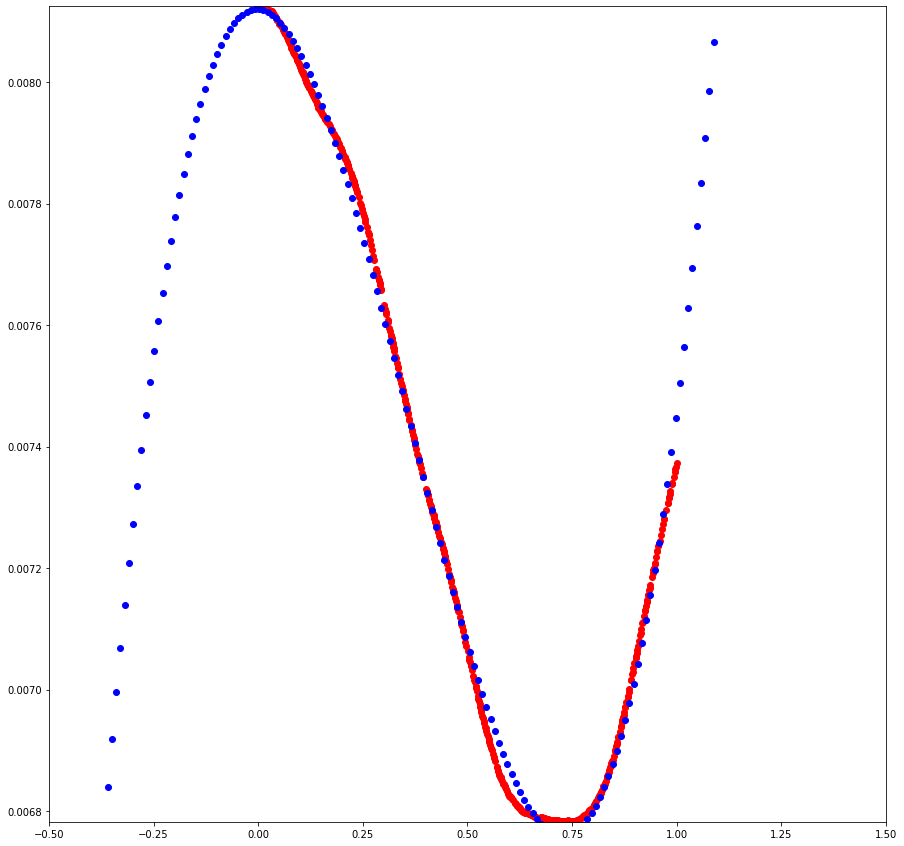

In [1384]:
kernel = ExpSineSquared(length_scale = 100, periodicity = 0.5, length_scale_bounds = (1E-3, 1E5),
                        periodicity_bounds = (1E-4, 1E3)) * DotProduct(sigma_0=1., sigma_0_bounds=(1e-05, 1e5))# \
#krreg = KernelRidge(alpha=0.00000001, kernel=kernel, gamma='linear', degree=5, coef0=1, kernel_params=None)

krreg = GaussianProcessRegressor(kernel=kernel, alpha=0.0000001)
0

X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

#X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

y = dfdebreg.loc[norads[oi_num]].ecc.values

minmaxe = MinMaxScaler()
minmaxt = MinMaxScaler()
minmaxt.fit(X.reshape(-1, 1))
minmaxe.fit(np.array([0,1]).reshape(-1, 1))
y = minmaxe.transform(y.reshape(-1, 1))
X = minmaxt.transform(X.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1), y,
                                                    test_size=0.33, random_state=42)
X_train = X
X_test = X
y_train = y
y_test = y
X_trainp = X_train
X_testp = X_test
X_testb = np.linspace(-0.5,1.5,200).reshape(-1,1)

#degree = 1
#poly_features = PolynomialFeatures(degree=degree)
#X_trainp = poly_features.fit_transform(X_train)
#X_testp = poly_features.fit_transform(X_test)
krreg.fit(X_trainp, y_train)

#y_pred = krreg.predict(X_testp)
y_pred = krreg.predict(X_testb)

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
plt.xlim(-0.5,1.5)
plt.ylim(np.min(y_test),np.max(y_test))
plt.scatter(X_test, y_test, c = 'red')
plt.scatter(X_testb, y_pred, c = 'blue')
# better oscillatory interpolation

0.10300066739558611


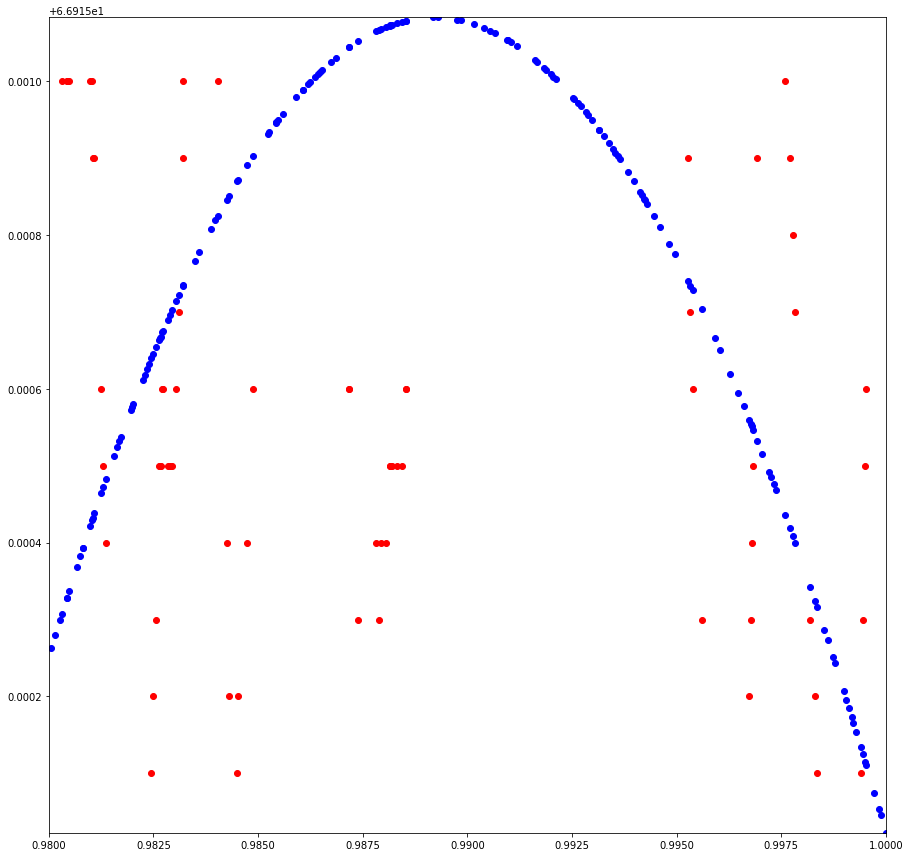

In [1285]:
#treereg = DecisionTreeRegressor(criterion = 'mae', max_depth = 8, min_samples_split = 2, min_samples_leaf = 1)
X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1), dfdebreg.loc[norads[oi_num]].inc.values,
                                                    test_size=0.33, random_state=42)

degree = 1
poly_features = PolynomialFeatures(degree=degree)
X_trainp = poly_features.fit_transform(X_train)
X_testp = poly_features.fit_transform(X_test)
krreg.fit(X_trainp, y_train)

y_pred = krreg.predict(X_testp)

print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
plt.xlim(0.98,1)
plt.ylim(np.min(y_pred),np.max(y_pred))
plt.scatter(X_test, y_test, c = 'red')
plt.scatter(X_test, y_pred, c = 'blue')
# better fourier series interpolation

doing 178 [0.98610989] [0.31258292]
doing 365 [0.97723729] [0.7021832]
[ 0.79593093 -2.56733706]
[ 0.79593093 -2.56733706]


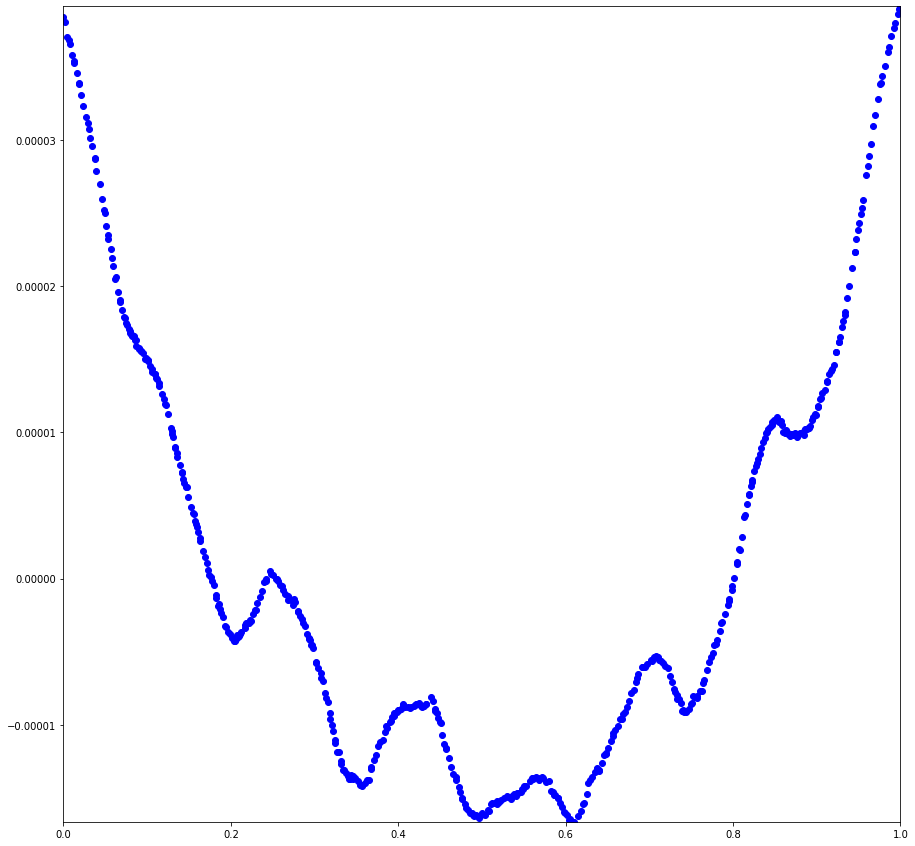

In [1286]:
#curve_fit fit of function

## perform curve_fit for raan
fitfunc = lambda x, p0, p1: (p0 + p1 * x) #% 1
# sortby datetime
dfsub = dfdebreg.loc[norads[oi_num]].sort_values('datetimes')
X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
X = dfsub.datetimes.apply(lambda x: x.timestamp()).values


#X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)
y = dfdebreg.loc[norads[oi_num]].raan.values
y = dfsub.raan.values

minmaxang = MinMaxScaler()
minmaxt = MinMaxScaler()
minmaxt.fit(X.reshape(-1, 1))
minmaxang.fit(np.array([0,360]).reshape(-1, 1))
y = minmaxang.transform(y.reshape(-1, 1))
X = minmaxt.transform(X.reshape(-1, 1))

# now split different regions according to distance
boundt = 0.7 ** 2
regions = list()#np.empty(shape = [9,2])#array()#(2,1)
#print(regions.shape)
sign = 1
yc = y[0]
for i, x in enumerate(X): # problem X is not ordered
    if(i > 0):
        dx = X[i] - X[i - 1]
        dy = y[i] - y[i - 1]
        dist = (dx ** 2 + dy ** 2)
        if dist > boundt: # do something
            print('doing', i, dist, X[i])
            #regions[i] = [X[i - 1], X[i]]
            #np.append(regions, [X[i - 1], X[i]], axis = 0)
            regions.append([X[i - 1], X[i], sign])
            yc = y[i]
        #elif dy <= 0: sign = -1 #can fail
        #else: sign = 1 
        if(y[i] - yc >= 0): sign = 1
        else: sign = -1
Xreg = X
ilower = 0;
#count = 1
for c in regions:
    for i in range(ilower, len(X)):
        if X[i] > c[0]:
            #Xreg.append
            y[i] += c[2]
            #count += c[2] 
            #pass
            
# Assume sign remains constant
#print(X[:,0])


X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1), y,
                                                    test_size=0.33, random_state=42)
init = [1,-3]
out2, cov_x2 = curve_fit(fitfunc, xdata = X_train.flatten(), ydata = y_train.flatten(), p0 = init)
print(out2)

degree = 1
poly_features = PolynomialFeatures(degree=degree)
X_trainp = poly_features.fit_transform(X_train)
X_testp = poly_features.fit_transform(X_test)
krreg.fit(X_trainp[:,1].reshape(-1,1), y_train)

#y_pred = krreg.predict(X_testp)
print(out2)
y_pred = fitfunc(X_testp, out2[0], out2[1])
y_pred2 = fitfunc(X, out2[0], out2[1])
#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
plt.xlim(0.,1.)
#plt.ylim(np.min(y_test),np.max(y_test))
plt.ylim(np.min(y_pred2 - y),np.max(y_pred2 - y))
#plt.ylim(-6,6)
#plt.scatter(X_test, y_test.flatten(), c = 'red')
#plt.scatter(X_testp[:, 1], y_pred[:, 1], c = 'blue')
#plt.scatter(X, y, c = 'red')
plt.scatter(X, y_pred2 - y, c = 'blue')
#better  
#y_train
#X_testp
#X_testp[:, 1]
#y_pred[:,1]
#regions
#y_test
#X_test
#regions
#y_pred

In [1287]:
#fluctuation in raan analyze

In [1288]:
#minmaxt.get_params()

In [1289]:
# Zyklizität in raan, meaning inclined plane changes with time, muss berücksichtigt werden, nicht geosynchrone Orbits
# implement linear regression with modulo 360

In [1290]:
#can work quite well, but highly unstable method; better take periodicity into account

In [1291]:
import scipy.integrate as integrate

In [1292]:
def nfunc(t):
    #t = minmaxt.inverse_transform(t)
    return minmaxn.inverse_transform(gprn.predict(np.array(t).reshape(1,-1)))[0][0]

In [1293]:
dfdebreg.loc[norads[oi_num]].info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 529 entries, 2018.9159129206284 to 2019.9118236931695
Data columns (total 12 columns):
m            529 non-null float64
argp         529 non-null float64
bstar        529 non-null float64
dn_o2        529 non-null float64
ecc          529 non-null float64
inc          529 non-null float64
n            529 non-null float64
raan         529 non-null float64
datetimes    529 non-null object
x            529 non-null float64
y            529 non-null float64
z            529 non-null float64
dtypes: float64(11), object(1)
memory usage: 53.7+ KB


In [1294]:
print(dfdebreg.loc[norads[oi_num]].tail(1).argp.values[0])
print(dfdebreg.loc[norads[oi_num]].head(1).argp.values[0])

35.0481
309.2051


In [1295]:
print(dfdebreg.loc[norads[oi_num]].tail(1).raan.values[0])
print(dfdebreg.loc[norads[oi_num]].head(1).raan.values[0])

82.2797
286.5213


In [1296]:
dfdebreg.loc[norads[oi_num]].tail(1).head(1).m.values[0]

325.4298

In [1297]:
te = minmaxt.transform(np.array([dfdebreg.loc[norads[oi_num]].tail(1).head(1).datetimes.values[0].timestamp()]).reshape(1,-1))

In [1298]:
# mean anomaly (m) calc
# integrate 360 * n over time n in terms of sec is n = n'/(24*3600)   gprn
# int n'(t)/240 dt, minmaxn, minmaxt
delt = minmaxt.inverse_transform(np.array([0,1]).reshape(1,-1))[0]
delt = delt[1] - delt[0]
t = 1
print(integrate.quad(nfunc, 0, te)[1] / 240 * delt)
(integrate.quad(nfunc, 0, te)[0] / 240 * delt + dfdebreg.loc[norads[oi_num]].m.values[0]) % 360
#dfdebreg.loc[norads[oi_num]].m.values[0]
#nfunc(0)
#minmaxn.inverse_transform(np.array([0,1]).reshape(1,-1))[0][1]

0.021446174305069725


324.99717859039083

In [1452]:
#oi_num2 = 19

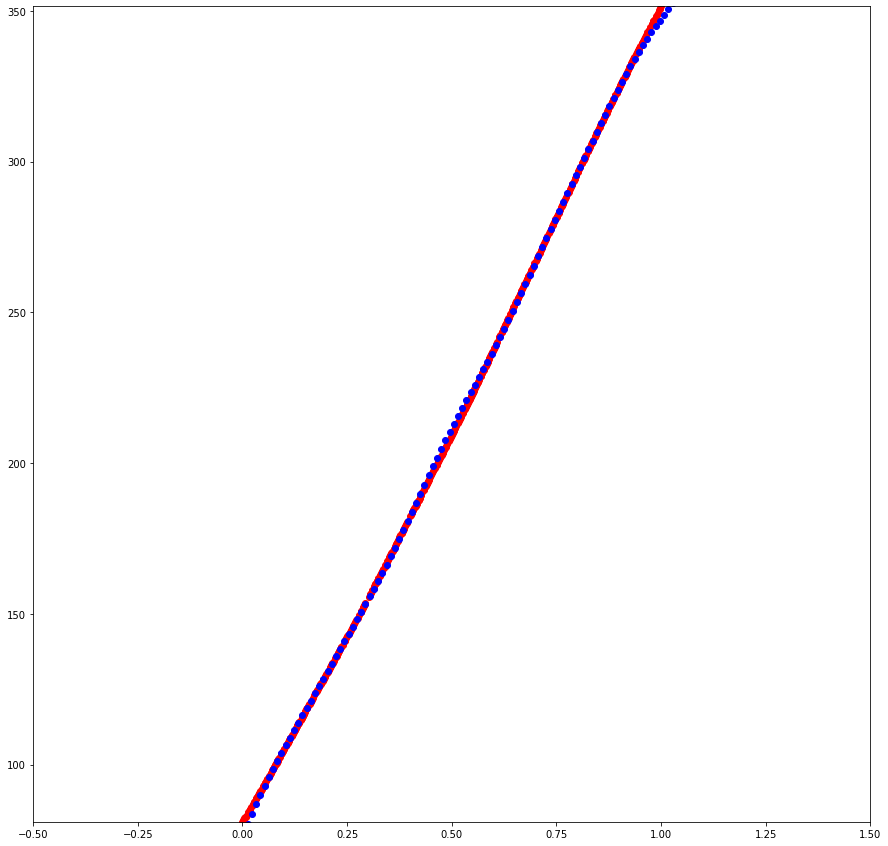

In [1454]:
kernel = ExpSineSquared(length_scale = 100, periodicity = 0.5, length_scale_bounds = (1E-3, 1E5),
                        periodicity_bounds = (1E-4, 1E3)) * DotProduct(sigma_0=1., sigma_0_bounds=(1e-05, 1e5))# \
#krreg = KernelRidge(alpha=0.00000001, kernel=kernel, gamma='linear', degree=5, coef0=1, kernel_params=None)

krreg = GaussianProcessRegressor(kernel=kernel, alpha=0.0000001)
0

X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

#X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

y = dfdebreg.loc[norads[oi_num]].m.values
#y = dfdebreg.loc[norads[oi_num]].argp.values

minmaxe = MinMaxScaler()
minmaxt = MinMaxScaler()
minmaxt.fit(X.reshape(-1, 1))
minmaxe.fit(np.array([0,1]).reshape(-1, 1))
y = minmaxe.transform(y.reshape(-1, 1))
X = minmaxt.transform(X.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1), y,
                                                    test_size=0.33, random_state=42)
X_train = X
X_test = X
y_train = y
y_test = y
X_trainp = X_train
X_testp = X_test
X_testb = np.linspace(-0.5,1.5,200).reshape(-1,1)

#degree = 1
#poly_features = PolynomialFeatures(degree=degree)
#X_trainp = poly_features.fit_transform(X_train)
#X_testp = poly_features.fit_transform(X_test)
krreg.fit(X_trainp, y_train)

#y_pred = krreg.predict(X_testp)
y_pred = krreg.predict(X_testb)

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
plt.xlim(-0.5,1.5)
plt.ylim(np.min(y_test),np.max(y_test))
plt.scatter(X_test, y_test, c = 'red')
plt.scatter(X_testb, y_pred, c = 'blue')
# better oscillatory interpolation